In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import HomeMade as hm
import xgboost as xgb
import seaborn as sb

Load data with all features

In [3]:
N = 1e8

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.7)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_slice = int(len(mc)*0.7)
train_mc = mc[:train_test_slice]
test_mc = mc[train_test_slice:]

Mass fit to select background and signal data:

In [131]:
from iminuit import Minuit
from AppStatFunctions import Chi2Regression, nice_string_output, add_text_to_ax
from scipy.optimize import curve_fit
from scipy.stats import norm, chi2

def fit_mass2(xs, vals, errs, ax = None, guesses_bkgr = [0, 0, -10, 2000], guesses_sig = [498, 6, 17000],plot=True):
    guesses_bkgr[-1] = 0.5*(vals[0] + vals[-1])
    guesses_sig[-1] = 20*max(vals)#np.sqrt(2*np.pi*guesses_sig[1]**2)*(max(vals))# - guesses_bkgr[-1])
    
    if not ax and plot:
        fig, ax = plt.subplots(figsize = (16, 10), ncols = 2)
        ax_sig = ax[1]
        ax_all = ax[0]
        ax_all.plot(xs, vals, 'r.')
        ax_all.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')

    def background_fit(x, a, b, c, d):
        return a * (x- 498) ** 3 + b * (x-498) ** 2 + c * (x-498) + d
    
    # The signal fit  Here gauss
    def sig1(x, mean, sig, size):
        return size*norm.pdf(x, mean, sig)
    
    def sig2(x, mean, sig, size):
        return size*norm.pdf(x, mean, sig)
    
    # The full fit
    def full_fit(x, mean, sig, size, f, sigmp, a, b, c, d):
        return background_fit(x, a, b, c, d) + f*sig1(x, mean, sig, size) + (1-f)*sig2(x, mean, sigmp*sig, size)
    
     # Background fit under here
    bkgr_mask = (xs < 475) | (xs > 525)
    vals_b, cov_b = curve_fit(background_fit, xs[bkgr_mask], vals[bkgr_mask], p0 = guesses_bkgr)
    b1, b2, b3, b4 = vals_b
    bkgr_chi2 = Chi2Regression(background_fit, xs[bkgr_mask], vals[bkgr_mask], errs[bkgr_mask])
    bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
    bkgr_min.migrad()
    counter = 0
    while not bkgr_min.valid and counter<50:
        bkgr_min.migrad()
        counter += 1
    if not bkgr_min.valid: print("No background valid minimum found!")
    
    #Save guesses 
    b1, b2, b3, b4 = bkgr_min.args
    s1, s2, s3 = guesses_sig
    
    # Full fit
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = s1, sig = s2, size = s3, f = 0.5, sigmp = 2)
    
    full_min.migrad()
    counter = 0
    while not full_min.valid and counter<200:
        full_min.migrad()
        counter += 1
    if not full_min.valid: print("No valid minimum found!")
    
    mean, sig, size, f, sigmp, b1, b2, b3, b4 = full_min.args
    
    sig_amount = np.sum(f*sig1(xs, mean, sig, size) + (1-f)*sig2(xs, mean, sigmp*sig, size))
    bak_amount = np.sum(background_fit(xs, b1, b2, b3, b4))
    
    if plot:
        ax_all.plot(xs, full_fit(xs, *full_min.args), "k-", label = "full_fit")
        ax_all.plot(xs, background_fit(xs, b1, b2, b3, b4),'b--',  label = "background_fit")

        ax_all.legend(loc = "upper right")

        # Details:
        text = {'chi2': full_min.fval, \
                'pval': chi2.sf(full_min.fval, len(xs) - len(full_min.args)), \
                'mean': f"{full_min.values['mean']:.1f} +/- {full_min.errors['mean']:.1f}",\
                'N':    f"{full_min.values['size']:.1f} +/- {full_min.errors['size']:.1f}"}

        text_output = nice_string_output(text)
        add_text_to_ax(0.60, 0.925, text_output, ax_all)

        # Plot signal seperately
        ax_sig.fill_between(xs, f*sig1(xs, mean, sig, size) + (1-f)*sig2(xs, mean, sigmp*sig, size), color = 'red', alpha = 0.5, label = "sig fit")
        ax_sig.plot(xs, f*sig1(xs, mean, sig, size),ls = '--', color = 'blue', alpha = 0.5, label = "sig fit")
        ax_sig.plot(xs, (1-f)*sig2(xs, mean, sigmp*sig, size),ls = '--', color = 'green', alpha = 0.5, label = "sig fit")

        vals_sig = vals - background_fit(xs, b1, b2, b3, b4)

        ax_sig.plot(xs, vals_sig, 'r.')
        ax_sig.errorbar(xs, vals_sig, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')



        text_a = {'sig': np.round(sig_amount), \
                  'bkgr': np.round(bak_amount), \
                  's/b': sig_amount / bak_amount}

        text_output = nice_string_output(text_a, decimals = 2)
        add_text_to_ax(0.70, 0.90, text_output, ax_sig)

        fig.tight_layout()
        return fig, ax, full_min, sig_amount, bak_amount
        
    return full_min, sig_amount, bak_amount

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


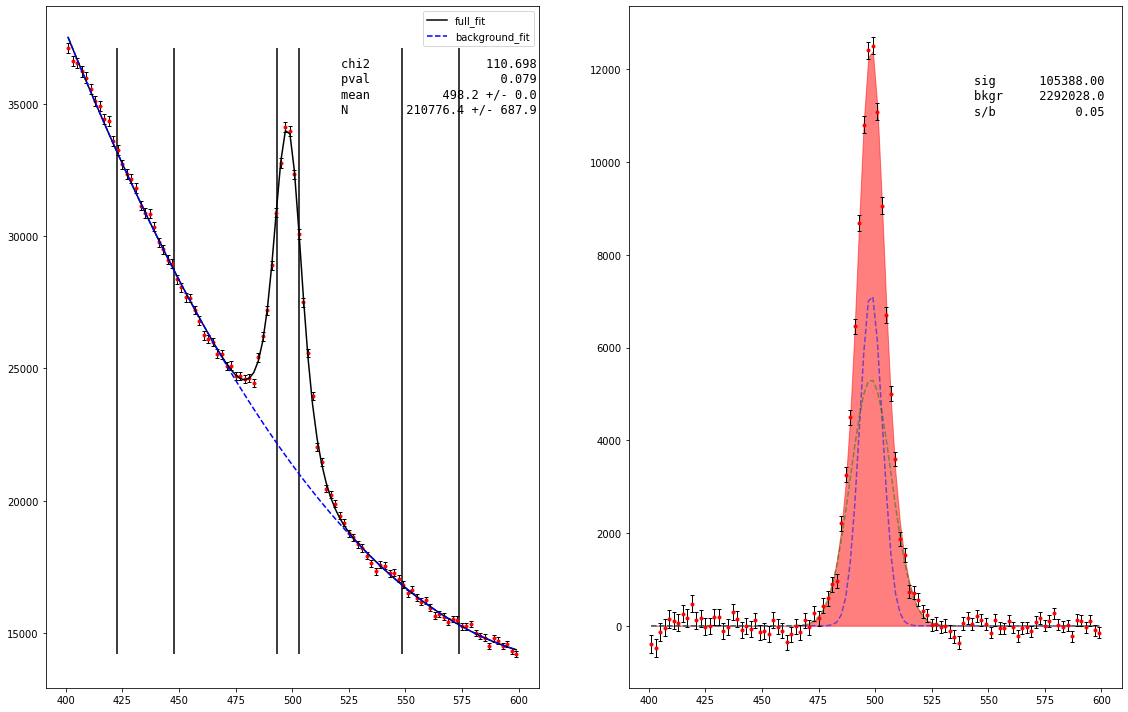

In [5]:
vals, binc, binw = hm.hist(train_data.v0_ks_mass,bins=100)
fig, ax, M, sig, bkgr = fit_mass2(binc,vals,np.sqrt(vals))

mean, sigma = M.values['mean'], M.values['sig']
signal = train_data.loc[(train_data.v0_ks_mass > mean - sigma) & (train_data.v0_ks_mass < mean + sigma)]
bkgr_l = train_data.loc[(train_data.v0_ks_mass > mean - 15*sigma) & (train_data.v0_ks_mass < mean - 10*sigma)]
bkgr_r = train_data.loc[(train_data.v0_ks_mass > mean + 10*sigma) & (train_data.v0_ks_mass < mean + 15*sigma)]
ax[0].vlines([mean-sigma,mean+sigma,mean-15*sigma,mean-10*sigma,mean+10*sigma,mean+15*sigma],min(vals),max(vals))

min_sample = min([len(signal),len(bkgr_l),len(bkgr_r)])
if min_sample != len(signal):print("WARNING! increase background samplesize or increase signal sample-size")


train_data = pd.concat([signal.sample(min_sample),
                   bkgr_l.sample(min_sample),
                   bkgr_r.sample(min_sample)])
train_data['y'] = np.append(np.ones(min_sample),[np.zeros(min_sample),np.zeros(min_sample)])

Define models: many features, few features, features PCAed

In [6]:
from sklearn.decomposition import PCA
import xgboost as xgb

cla_max = xgb.XGBClassifier()
cla_PCA = xgb.XGBClassifier()
# cla_min = xgb.XGBClassifier()

In [7]:
train_data.columns,test_data.columns

(Index(['v0_ks_mass', 'v0_ks_massErr', 'pv0_x', 'pv0_y', 'pv0_z', 'a0xy', 'a0',
        'a0z', 'cosTheta', 'v0_chi2', 'v0_x', 'v0_y', 'v0_z', 'v0_rxy',
        'v0_rxyErr', 'v0_px', 'v0_py', 'v0_pz', 'v0_pt', 'v0_p', 'v0_ptErr',
        'v0_px1', 'v0_py1', 'v0_pz1', 'v0_pt1', 'v0_p1', 'v0_px2', 'v0_py2',
        'v0_pz2', 'v0_pt2', 'v0_p2', 'v0_phi1', 'v0_theta1', 'v0_qOverP1',
        'v0_phi2', 'v0_theta2', 'v0_qOverP2', 'alpha', 'calpha', 'epsilon1',
        'epsilon2', 'Alpha', 'pL1', 'pL2', 'pT', 'thetastar', 'rapidity_ks',
        'pseudorapidity', 'y'],
       dtype='object'),
 Index(['v0_ks_mass', 'v0_ks_massErr', 'pv0_x', 'pv0_y', 'pv0_z', 'a0xy', 'a0',
        'a0z', 'cosTheta', 'v0_chi2', 'v0_x', 'v0_y', 'v0_z', 'v0_rxy',
        'v0_rxyErr', 'v0_px', 'v0_py', 'v0_pz', 'v0_pt', 'v0_p', 'v0_ptErr',
        'v0_px1', 'v0_py1', 'v0_pz1', 'v0_pt1', 'v0_p1', 'v0_px2', 'v0_py2',
        'v0_pz2', 'v0_pt2', 'v0_p2', 'v0_phi1', 'v0_theta1', 'v0_qOverP1',
        'v0_phi2', 'v0_theta

Maximum ML:

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

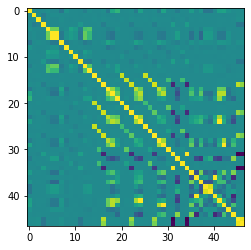

In [8]:
plt.imshow(train_data[train_data.columns[1:-1]].corr())

cla_max.fit(train_data[train_data.columns[1:-1]],y=train_data.y)

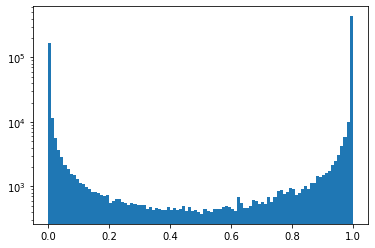

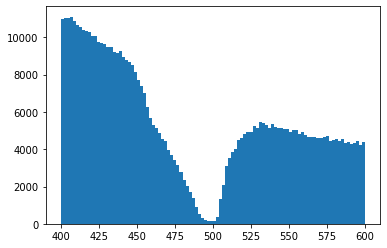

In [93]:
fig, ax = plt.subplots()
p = cla_max.predict_proba(test_data[test_data.columns[1:]])[:,0]
ax.hist(p,bins=100);
ax.set_yscale('log')

fig, ax = plt.subplots()
ax.hist(test_data.loc[p>0.01].v0_ks_mass,bins=100);

Medium ML / PCA:

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

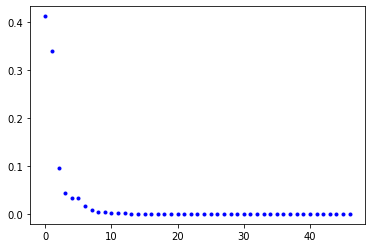

In [111]:
pca = PCA()
pca.fit(train_data[train_data.columns[1:-1]])

fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_,'b.')

pca = PCA(n_components=6)
cla_PCA.fit(pca.fit_transform(train_data[train_data.columns[1:-1]]),y=train_data.y)

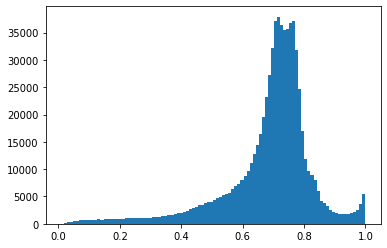

In [112]:
fig, ax = plt.subplots()
# pca = PCA(n_components=6)
p = cla_PCA.predict_proba(pca.transform(test_data[test_data.columns[1:]]))[:,0]
ax.hist(p,bins=100);
# ax.set_yscale('log')

In [113]:
def ROC_data(mass, p):
    tmp_p = np.sort(p)
    p_ranges = tmp_p[np.linspace(0,len(tmp_p)-1,20,dtype=int)]
    
    sig_count, bkgr_count = [], []
    sig_count_err, bkgr_count_err = [], []
    
    mass_fig, mass_ax = plt.subplots(figsize=(16,10))
    
    for i, score in enumerate(p_ranges):
        print(i)
        vals, binc, binw = hm.hist(mass.loc[p<score],bins=100)
        if all(vals == 0):
            continue
        
        mass_ax.plot(binc,vals,c='grey',alpha=0.5)
        
        fig, ax, M, sig, bkgr = fit_mass2(binc,vals,np.sqrt(vals),plot=True)
        
        sig_count.append(sig)
        bkgr_count.append(bkgr)
    return sig_count, bkgr_count

0
1
2
3
4
5
6
7
No background valid minimum found!
8
9


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


10
11
12
No valid minimum found!
13


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!
14
15
16
No background valid minimum found!
17


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


18


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


19


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


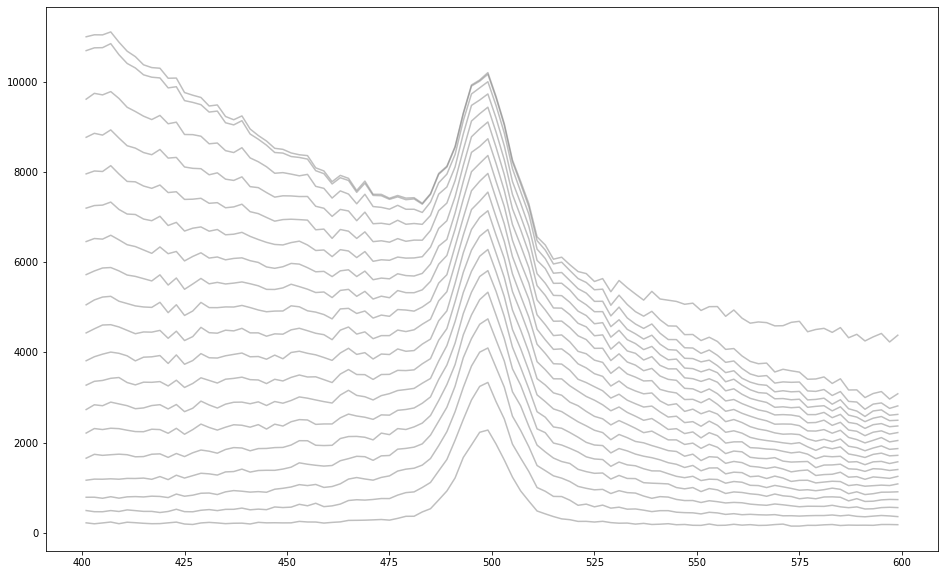

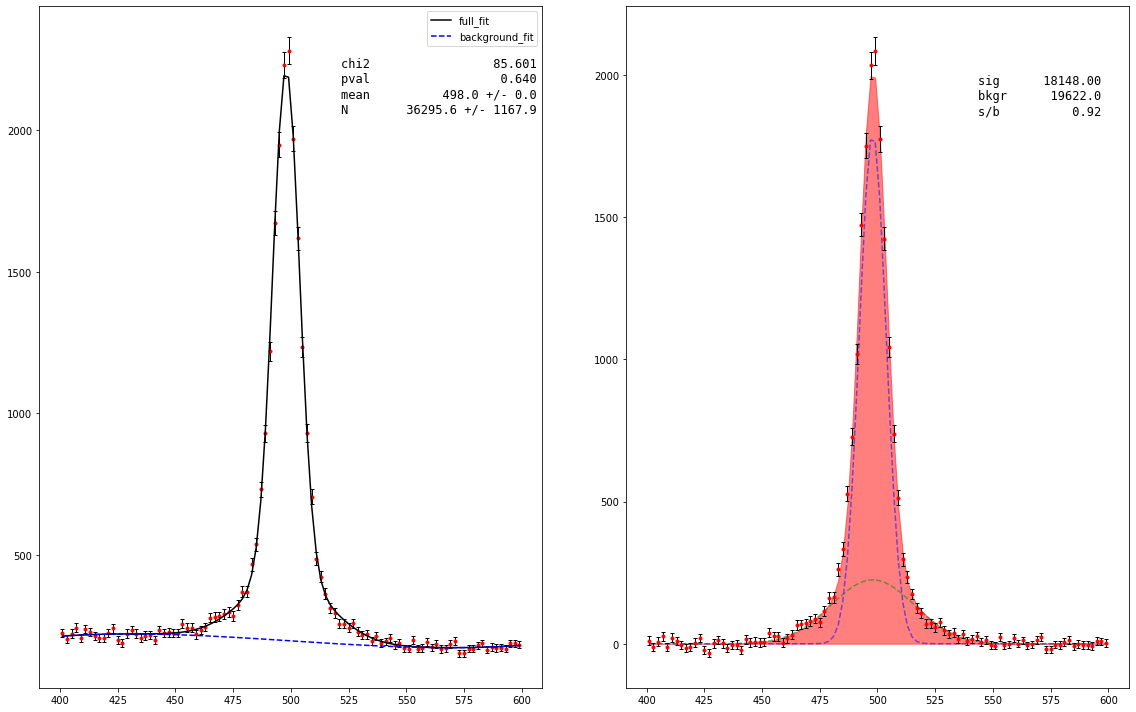

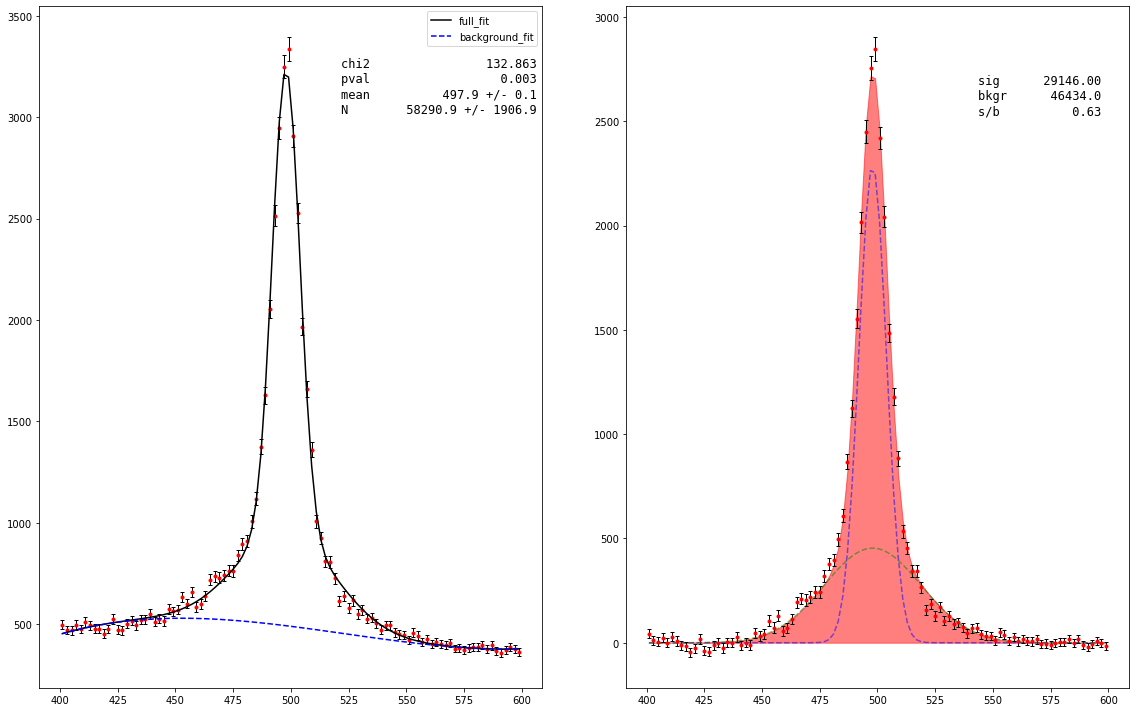

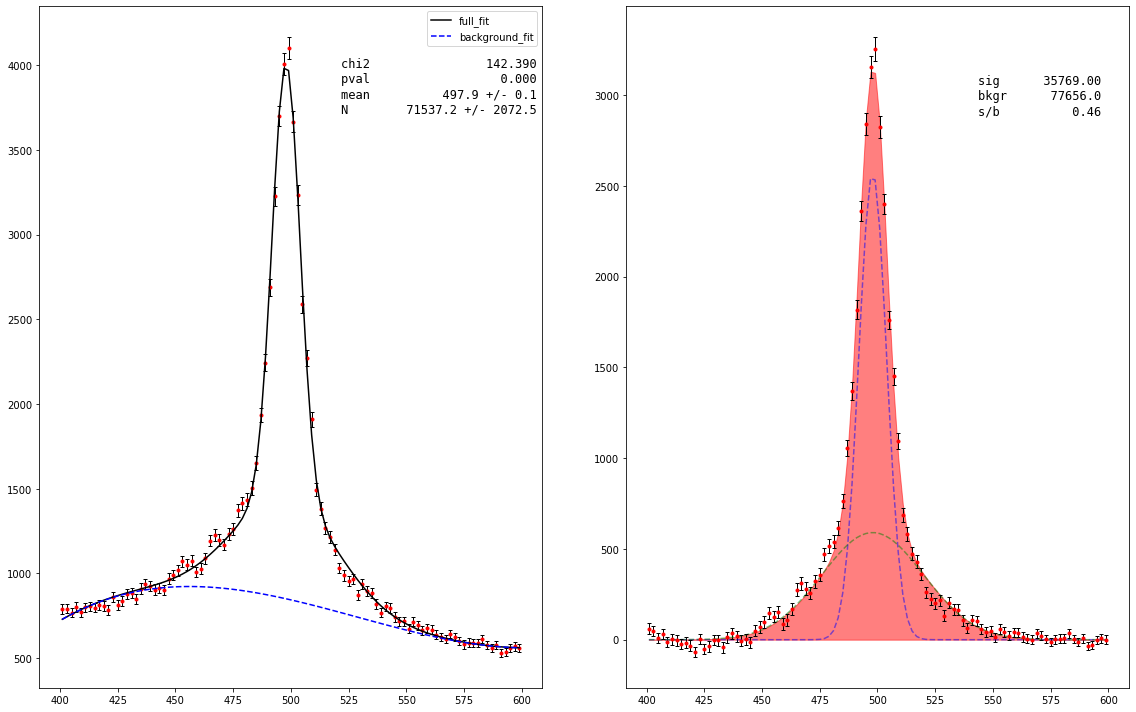

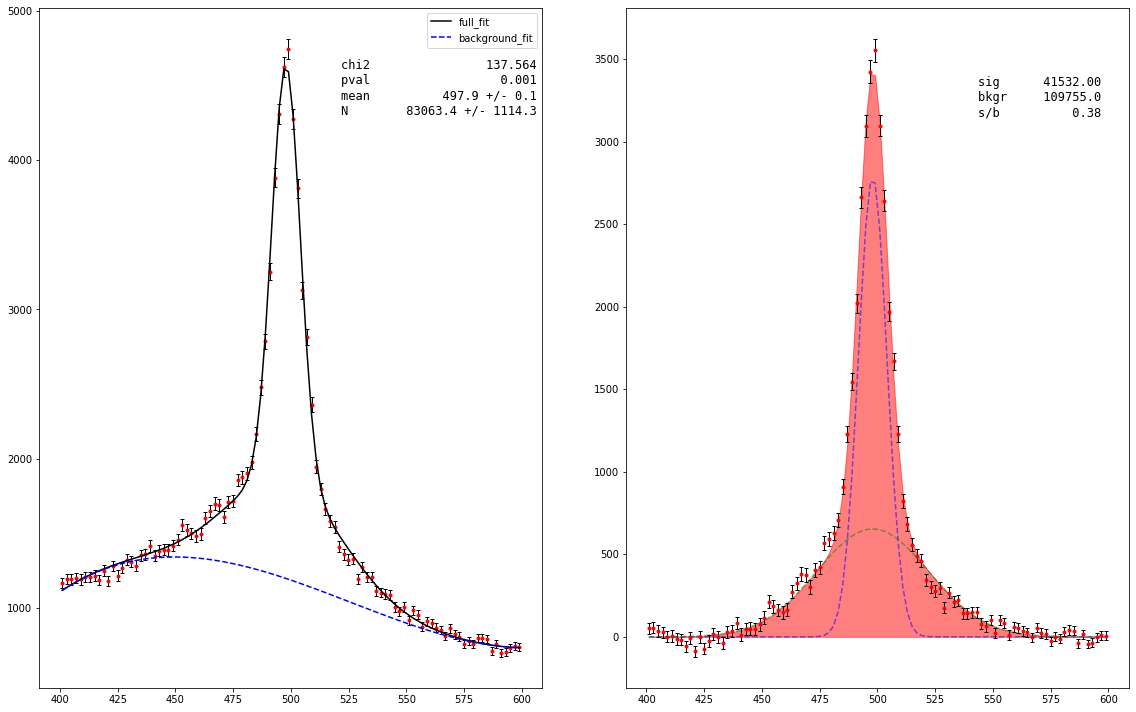

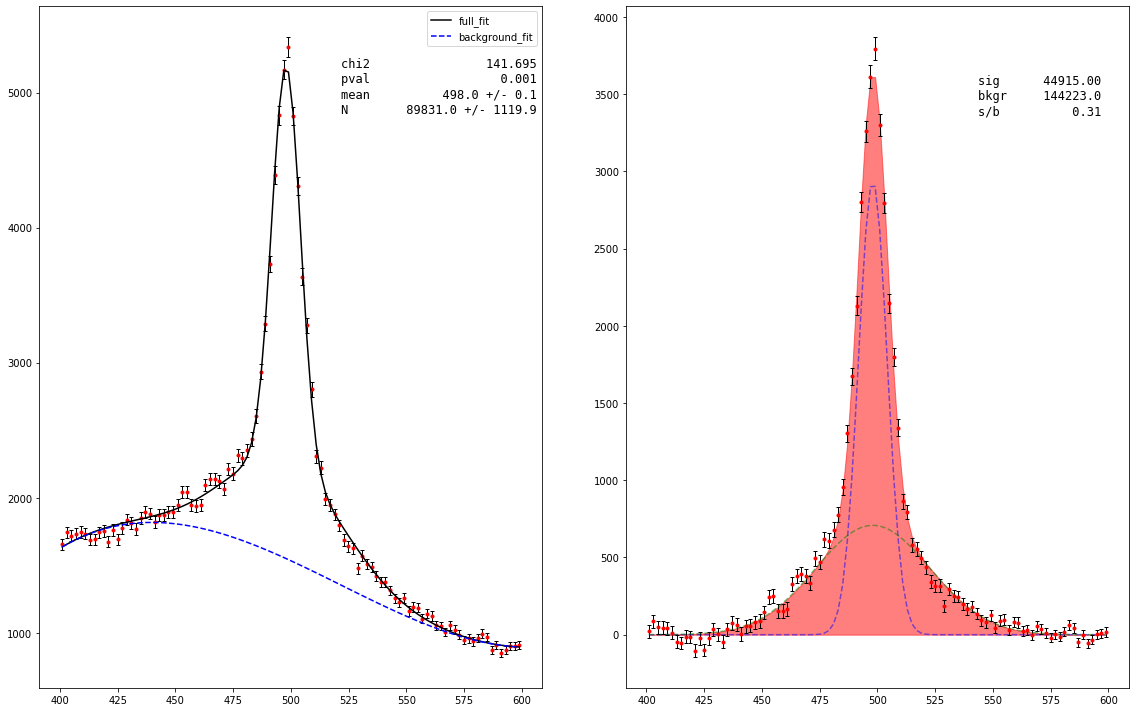

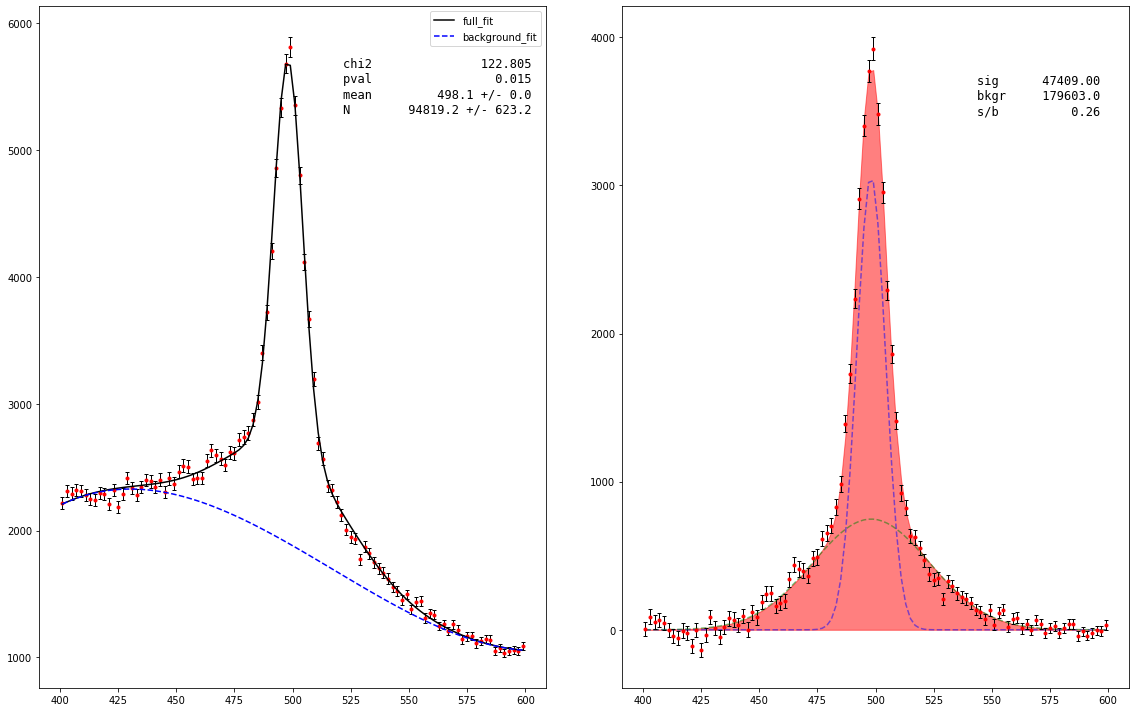

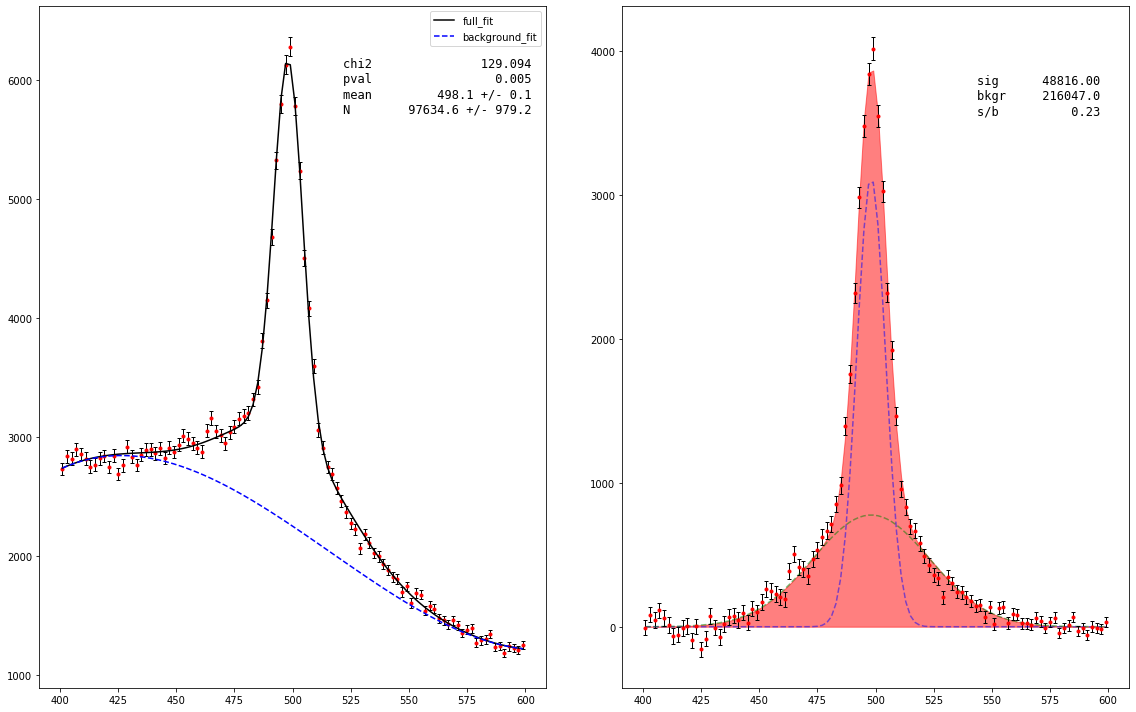

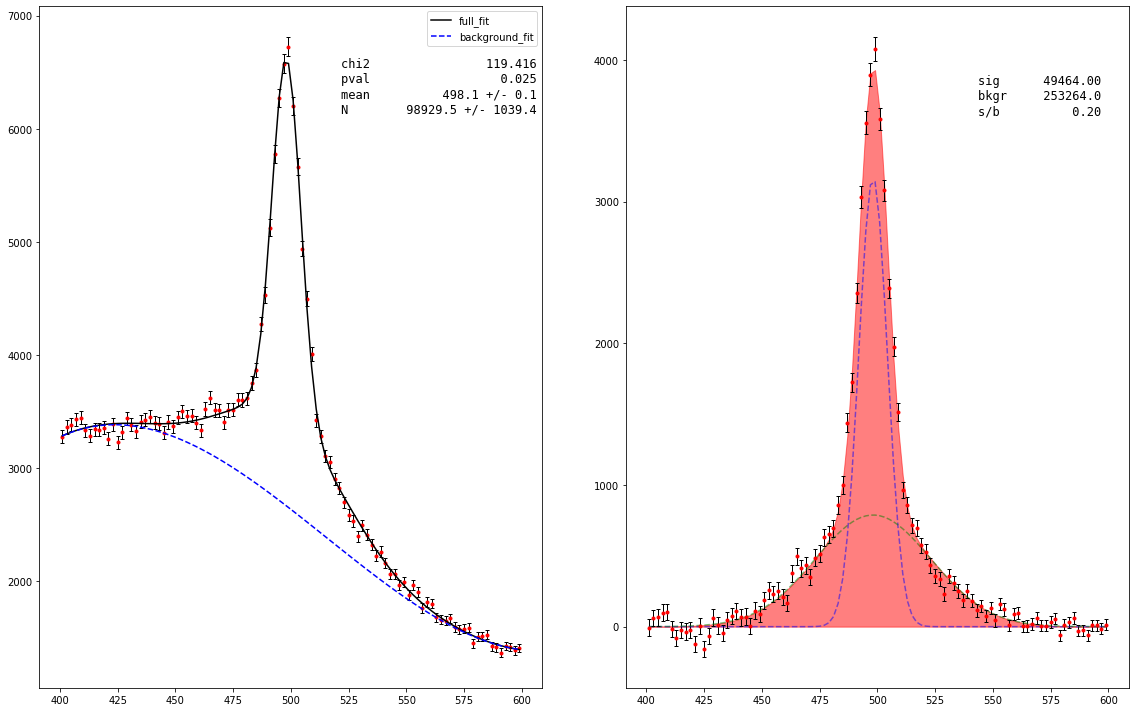

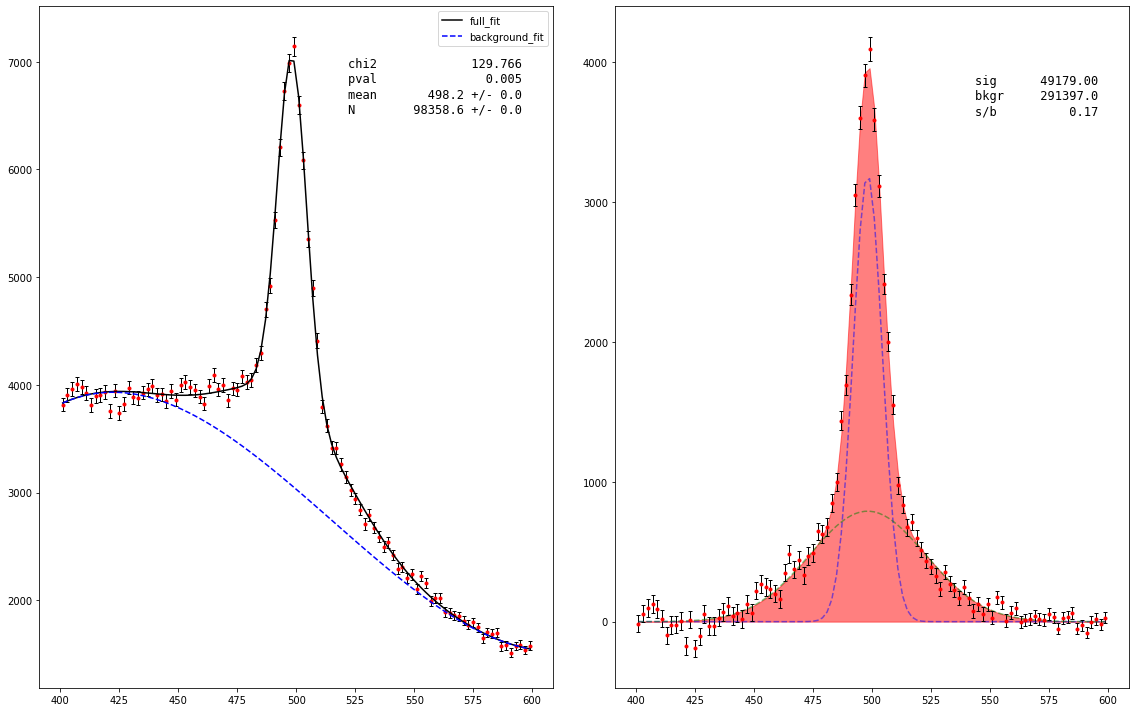

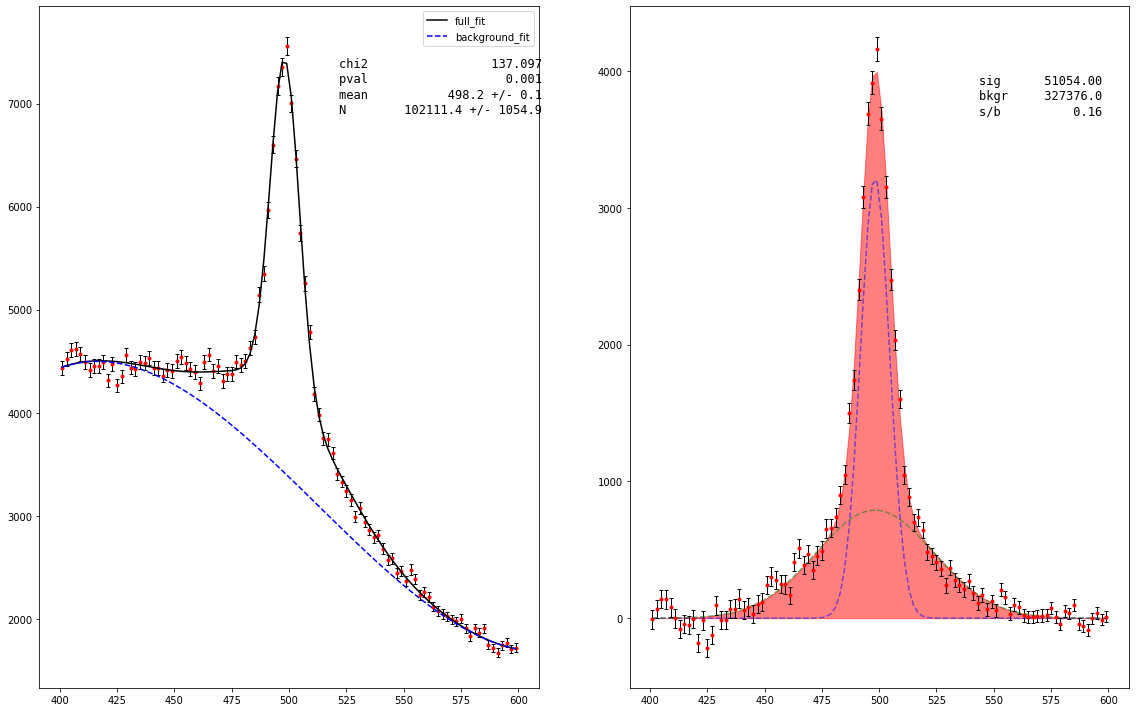

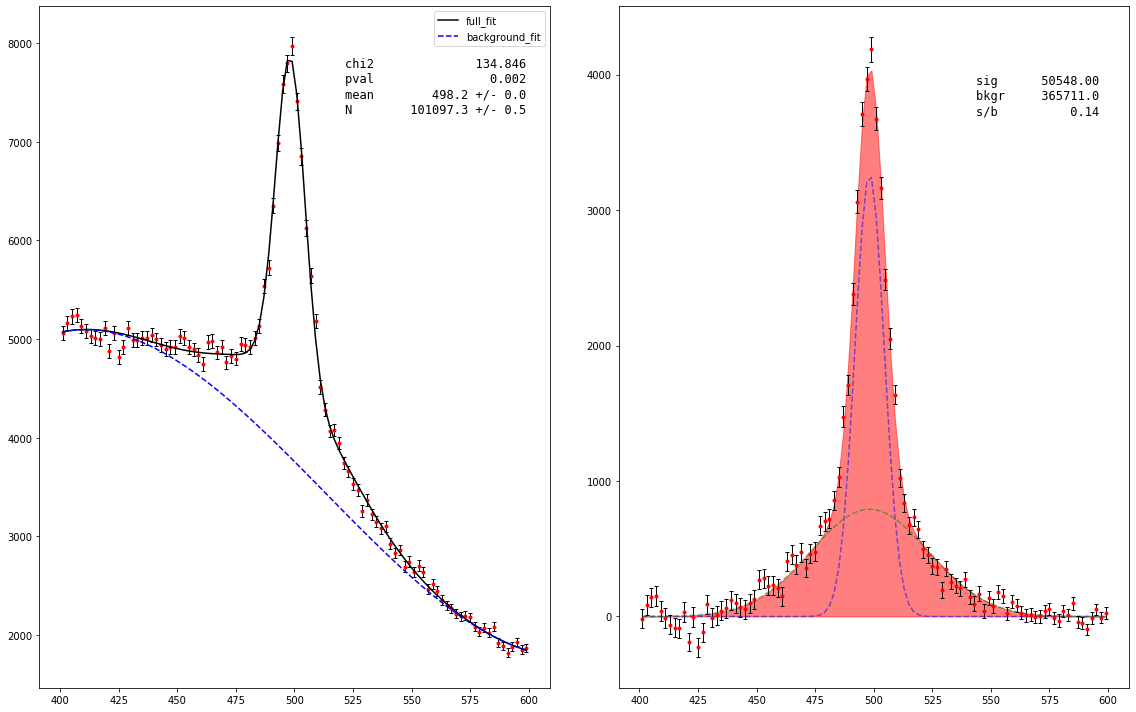

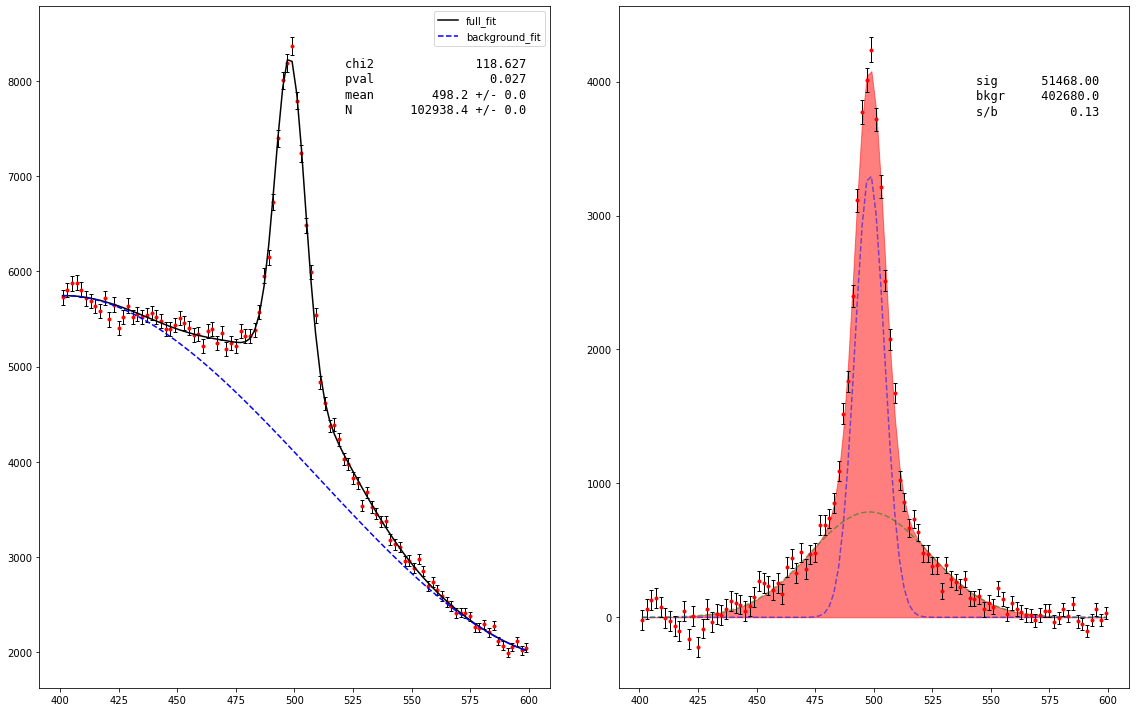

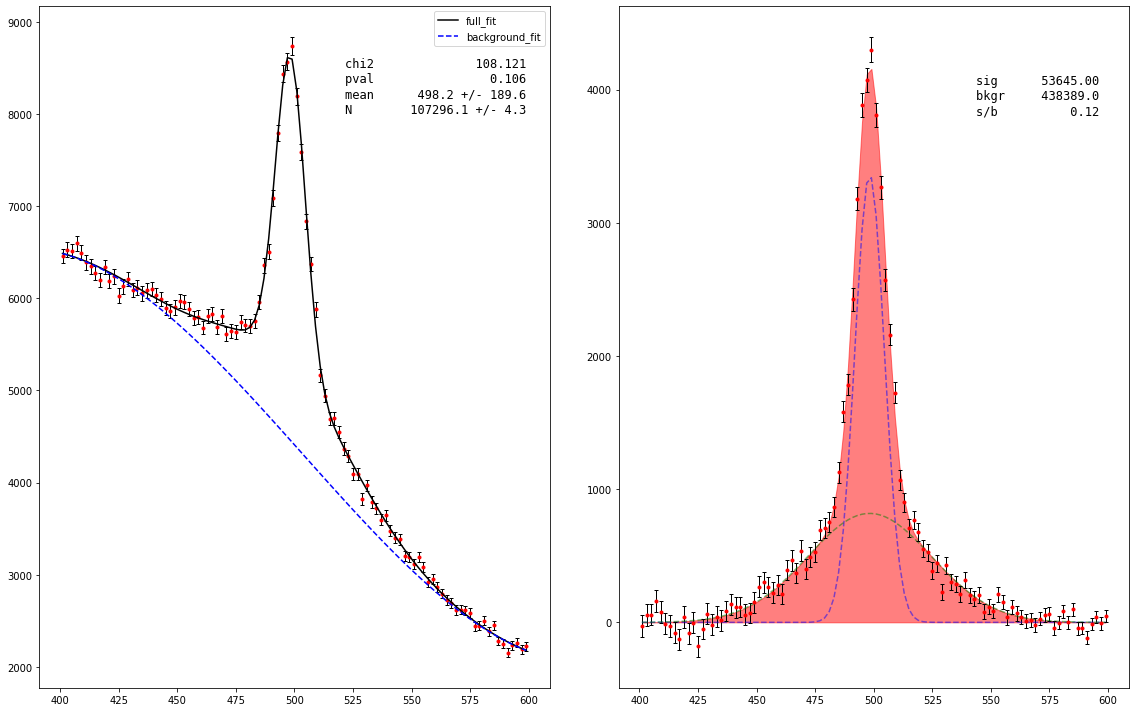

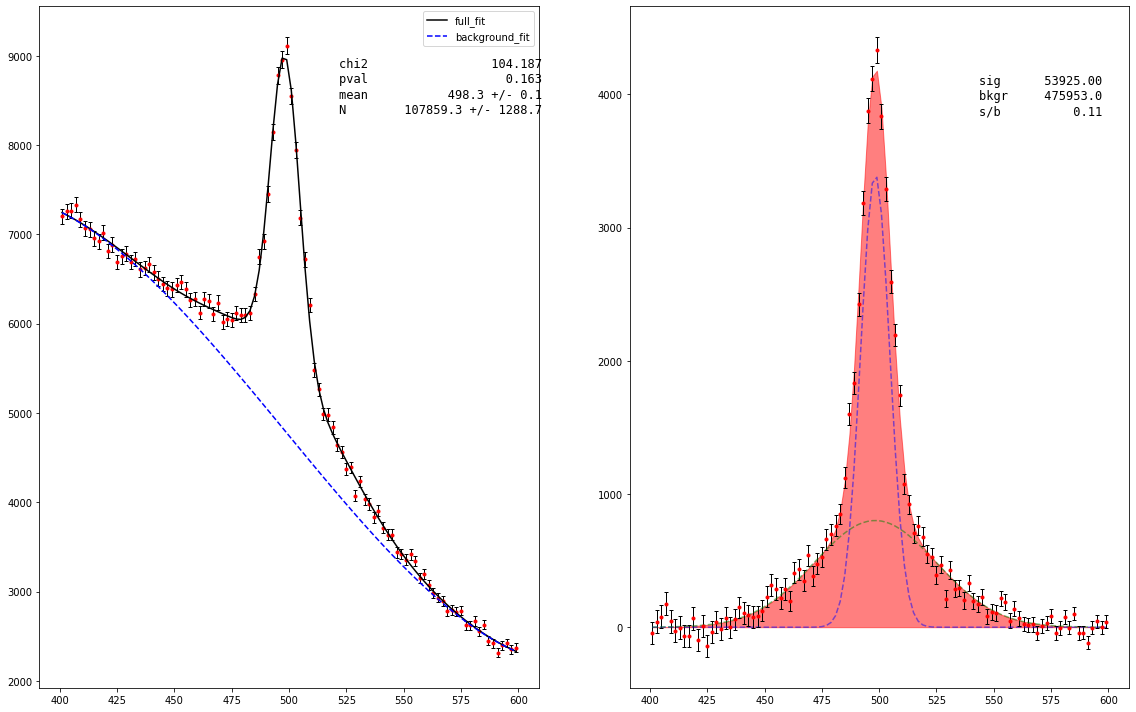

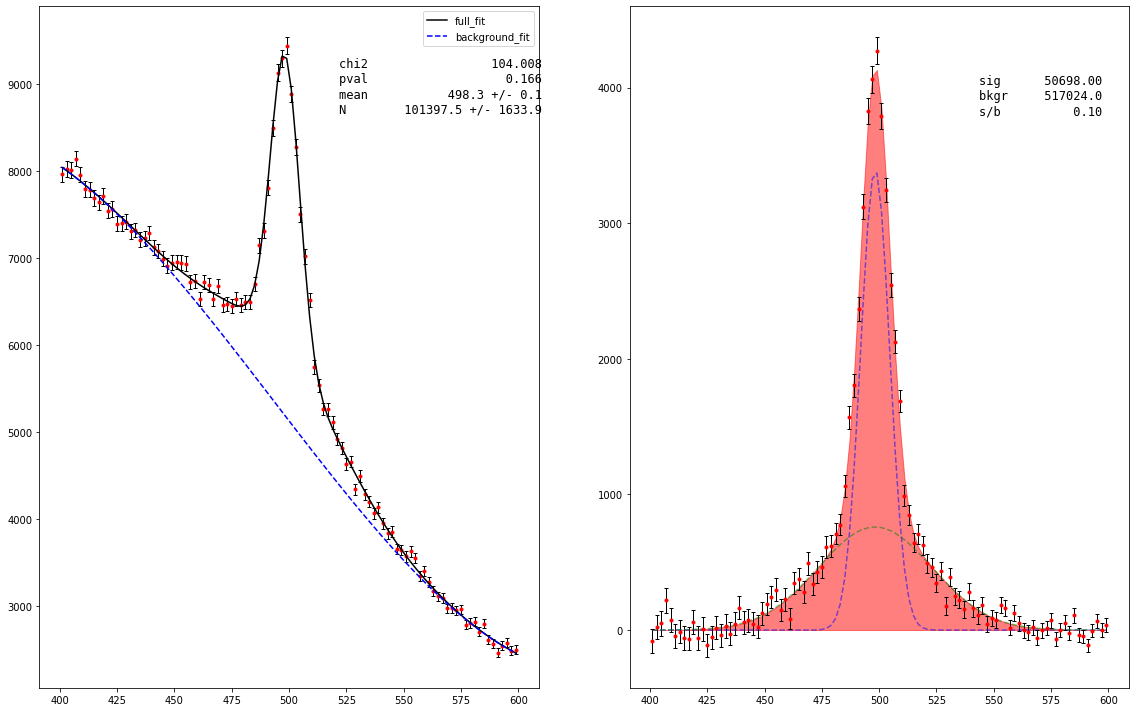

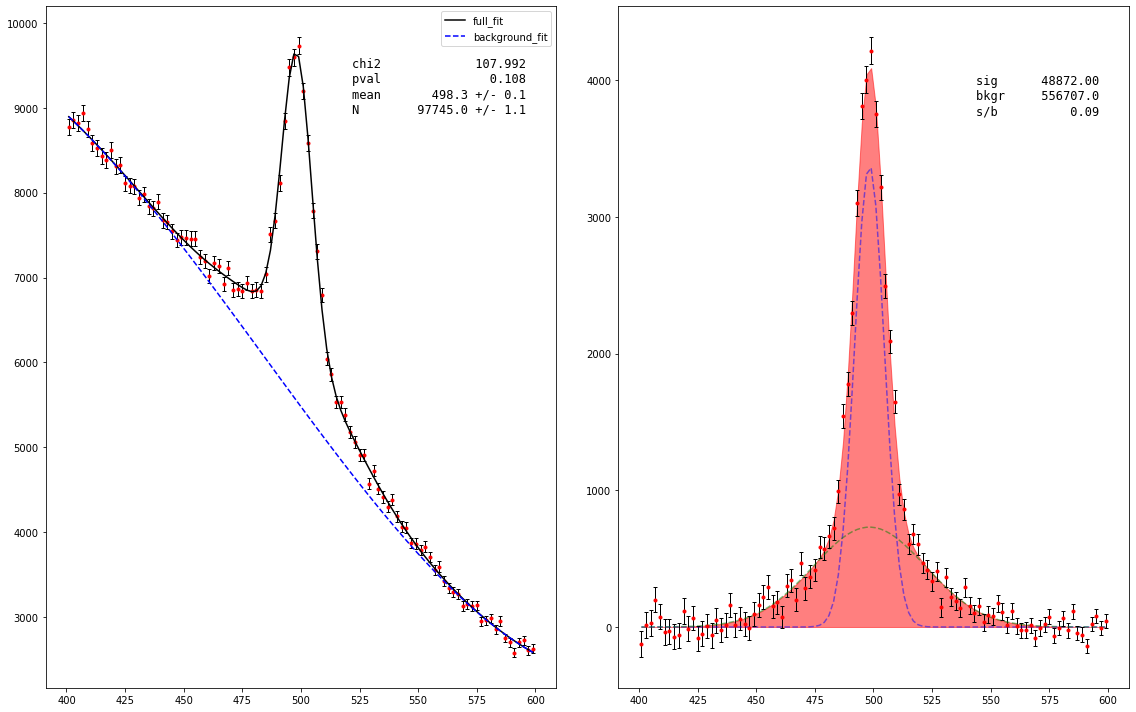

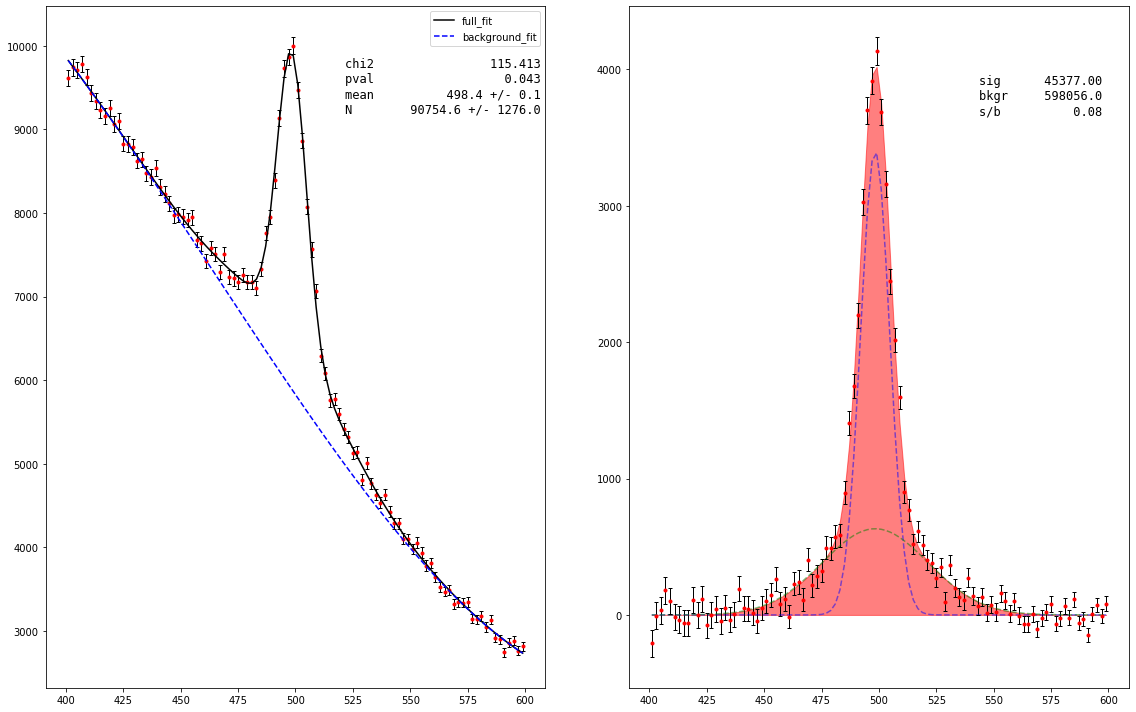

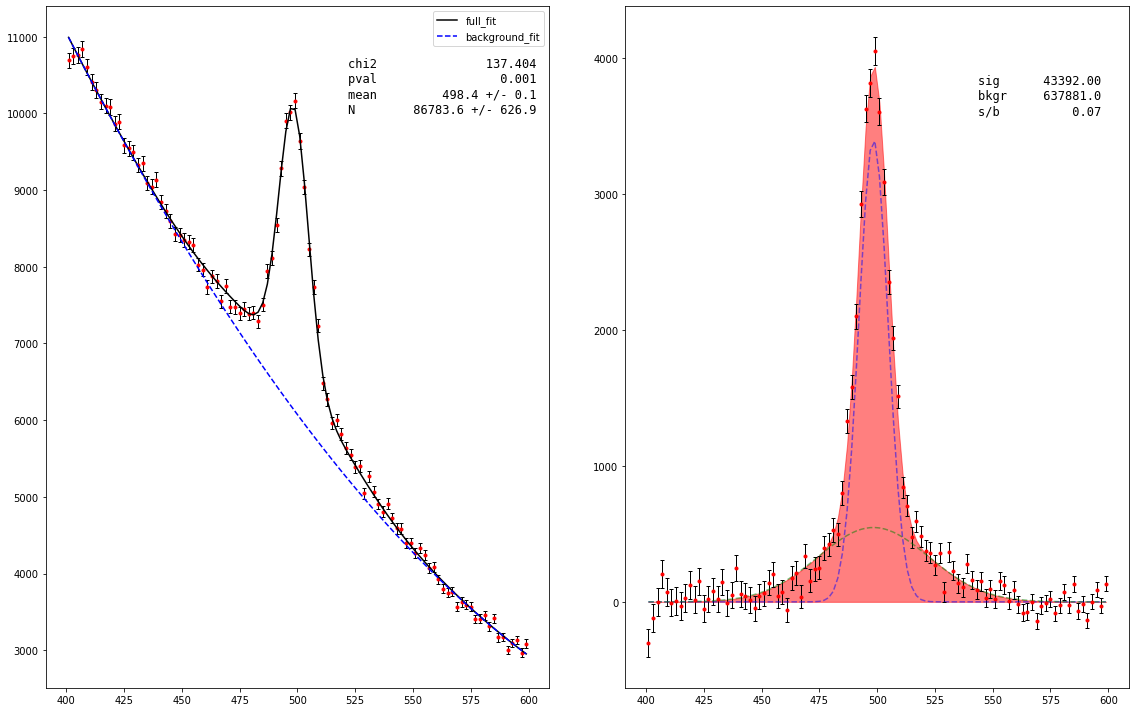

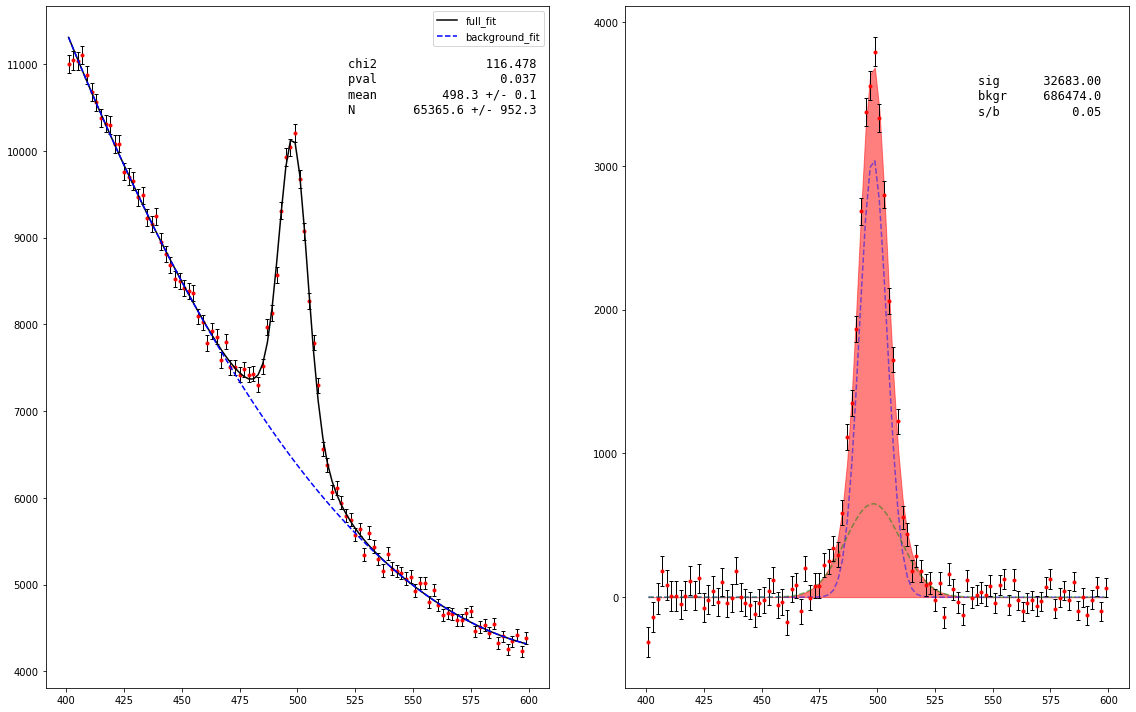

In [114]:
s, b = ROC_data(test_data.v0_ks_mass,p)

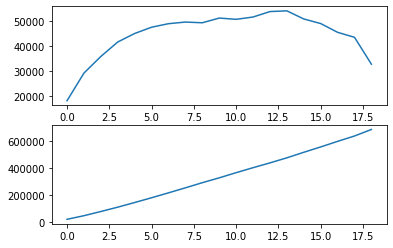

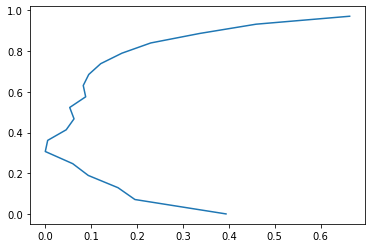

In [115]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(s)
ax[1].plot(b)
fig, ax = plt.subplots()
ax.plot(1 - np.asarray(s)/max(s), 1 - np.asarray(b)/max(b))

Do the same for cla_PCA in MC to investigate if ROC method is viable:

No valid minimum found!
WARNING! increase background samplesize or increase signal sample-size


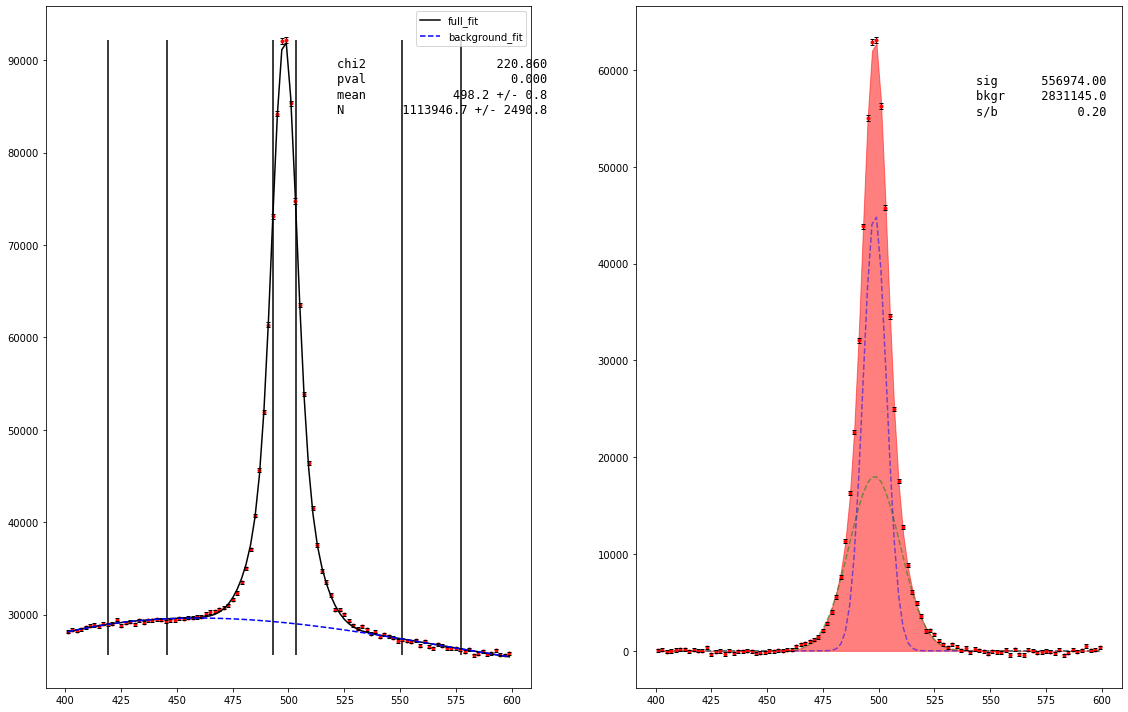

In [98]:
vals, binc, binw = hm.hist(train_mc.v0_ks_mass,bins=100)
fig, ax, M, sig, bkgr = fit_mass2(binc,vals,np.sqrt(vals))

mean, sigma = M.values['mean'], M.values['sig']
signal = train_mc.loc[(train_mc.v0_ks_mass > mean - sigma) & (train_mc.v0_ks_mass < mean + sigma)]
bkgr_l = train_mc.loc[(train_mc.v0_ks_mass > mean - 15*sigma) & (train_mc.v0_ks_mass < mean - 10*sigma)]
bkgr_r = train_mc.loc[(train_mc.v0_ks_mass > mean + 10*sigma) & (train_mc.v0_ks_mass < mean + 15*sigma)]
ax[0].vlines([mean-sigma,mean+sigma,mean-15*sigma,mean-10*sigma,mean+10*sigma,mean+15*sigma],min(vals),max(vals))

min_sample = min([len(signal),len(bkgr_l),len(bkgr_r)])
# if min_sample != len(signal):print("WARNING! increase background samplesize or increase signal sample-size")


train_mc = pd.concat([signal.sample(min_sample),
                   bkgr_l.sample(min_sample),
                   bkgr_r.sample(min_sample)])
train_mc['y'] = np.append(np.ones(min_sample),[np.zeros(min_sample),np.zeros(min_sample)])

In [103]:
train_mc.columns,test_mc.columns

(Index(['v0_ks_mass', 'v0_ks_massErr', 'pv0_x', 'pv0_y', 'pv0_z', 'a0xy', 'a0',
        'a0z', 'cosTheta', 'v0_chi2', 'v0_x', 'v0_y', 'v0_z', 'v0_rxy',
        'v0_rxyErr', 'v0_px', 'v0_py', 'v0_pz', 'v0_pt', 'v0_p', 'v0_ptErr',
        'v0_px1', 'v0_py1', 'v0_pz1', 'v0_pt1', 'v0_p1', 'v0_px2', 'v0_py2',
        'v0_pz2', 'v0_pt2', 'v0_p2', 'v0_phi1', 'v0_theta1', 'v0_qOverP1',
        'v0_phi2', 'v0_theta2', 'v0_qOverP2', 'alpha', 'calpha', 'epsilon1',
        'epsilon2', 'Alpha', 'pL1', 'pL2', 'pT', 'thetastar', 'rapidity_ks',
        'pseudorapidity', 'trueKs', 'y'],
       dtype='object'),
 Index(['v0_ks_mass', 'v0_ks_massErr', 'pv0_x', 'pv0_y', 'pv0_z', 'a0xy', 'a0',
        'a0z', 'cosTheta', 'v0_chi2', 'v0_x', 'v0_y', 'v0_z', 'v0_rxy',
        'v0_rxyErr', 'v0_px', 'v0_py', 'v0_pz', 'v0_pt', 'v0_p', 'v0_ptErr',
        'v0_px1', 'v0_py1', 'v0_pz1', 'v0_pt1', 'v0_p1', 'v0_px2', 'v0_py2',
        'v0_pz2', 'v0_pt2', 'v0_p2', 'v0_phi1', 'v0_theta1', 'v0_qOverP1',
        'v0_phi2',

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

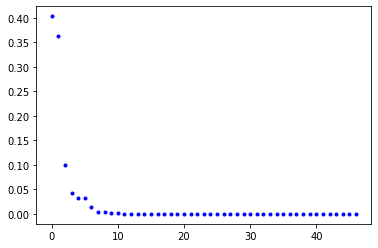

In [116]:
pca = PCA()
pca.fit(train_mc[train_mc.columns[1:-2]])

fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_,'b.')

pca = PCA(n_components=6)
cla_PCA.fit(pca.fit_transform(train_mc[train_mc.columns[1:-2]]),y=train_mc.y)

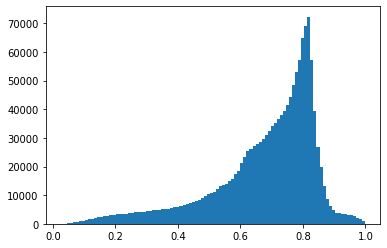

In [117]:
fig, ax = plt.subplots()
# pca = PCA(n_components=6)
p = cla_PCA.predict_proba(pca.transform(test_mc[test_mc.columns[1:-1]]))[:,0]
ax.hist(p,bins=100);

0
1


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


2


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


No valid minimum found!
3
4
5
No background valid minimum found!


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


6
7
8
9
10
11
12
13


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


14
15
No background valid minimum found!
16
17
No valid minimum found!
18


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


19


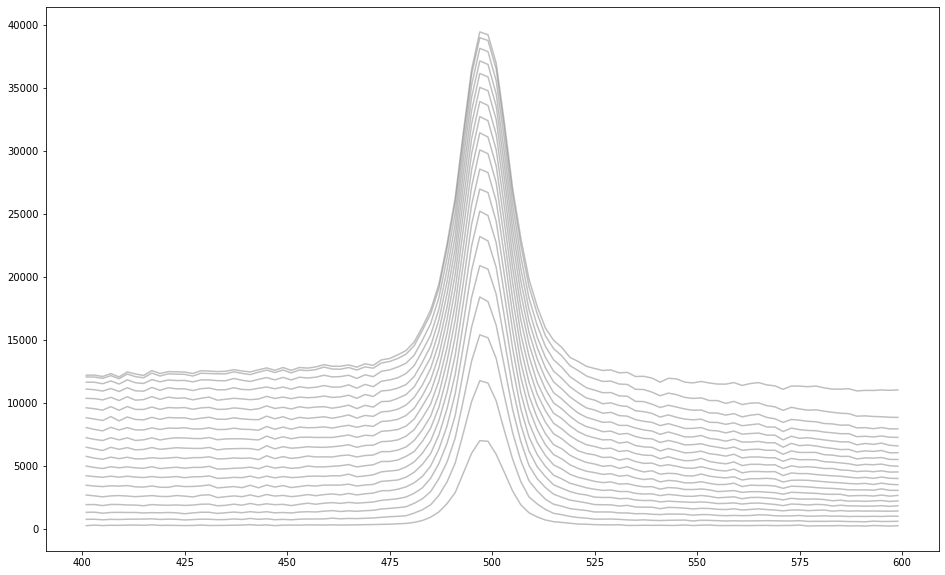

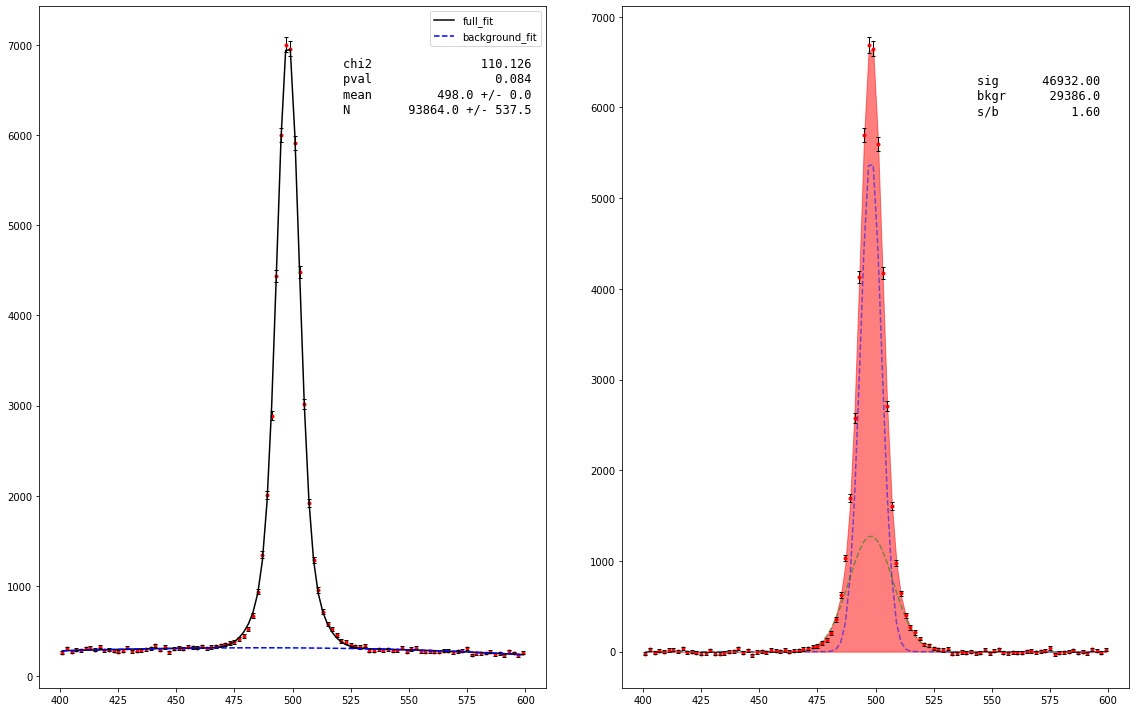

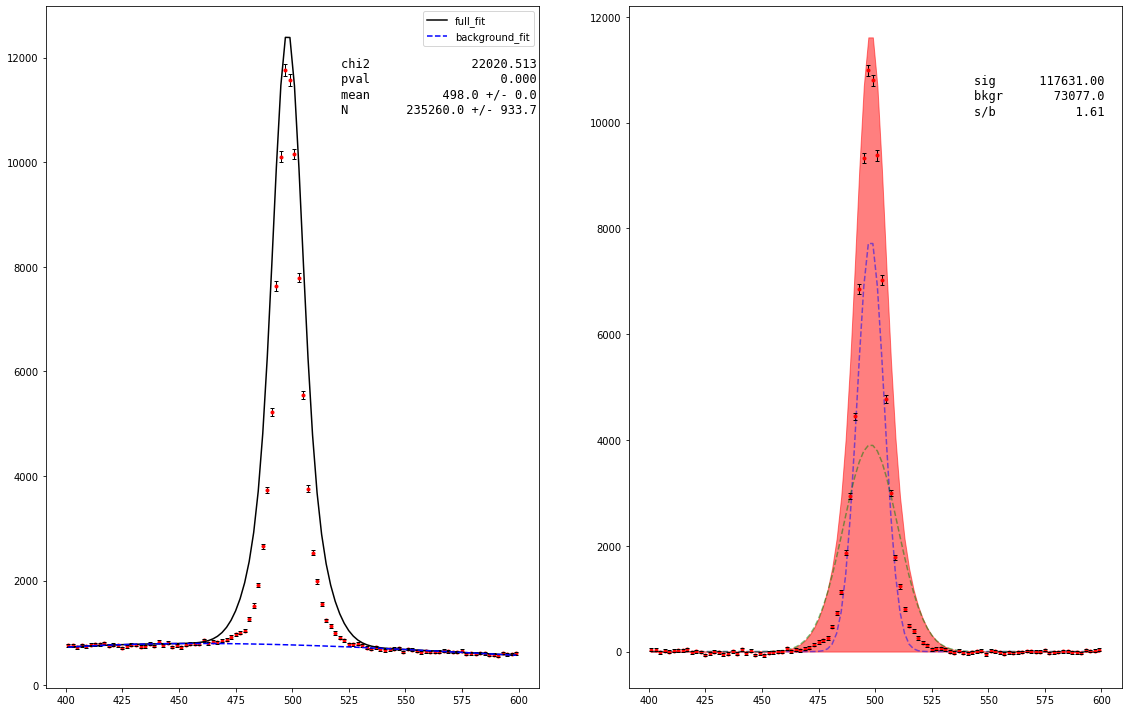

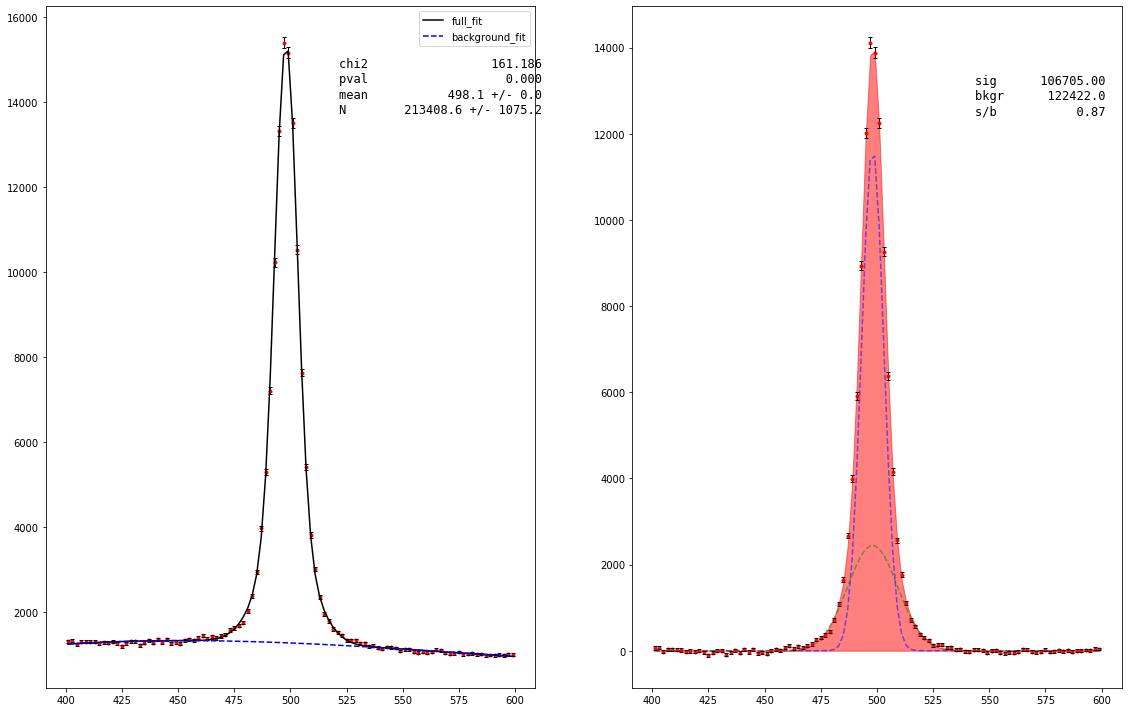

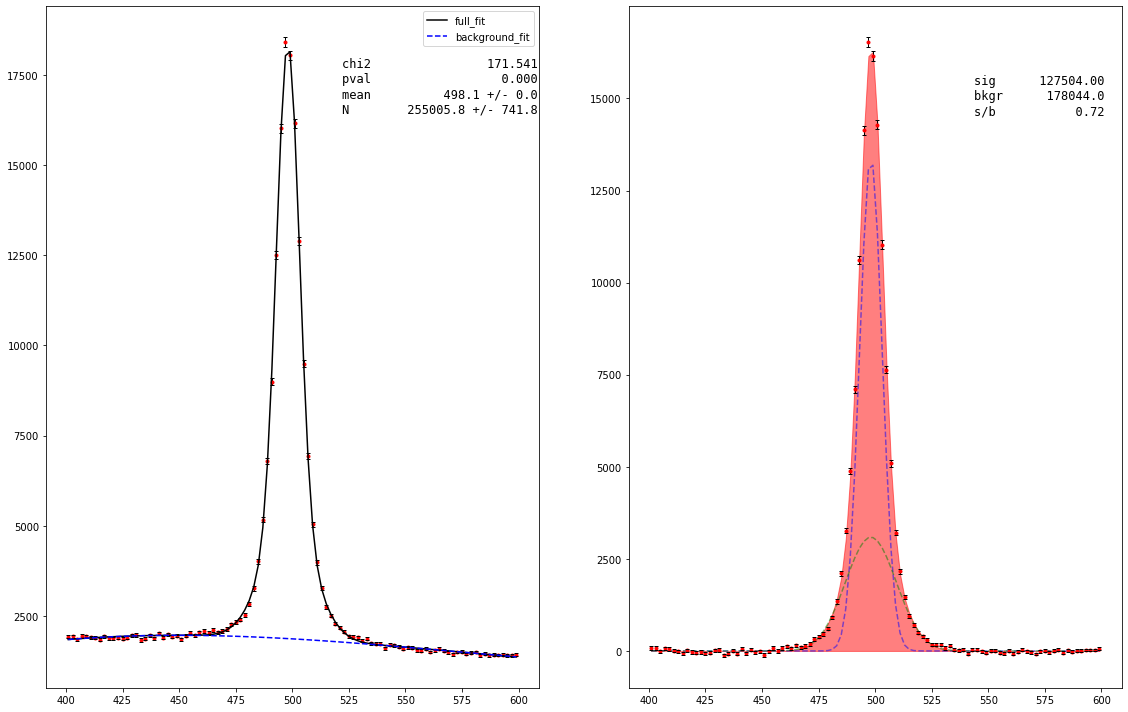

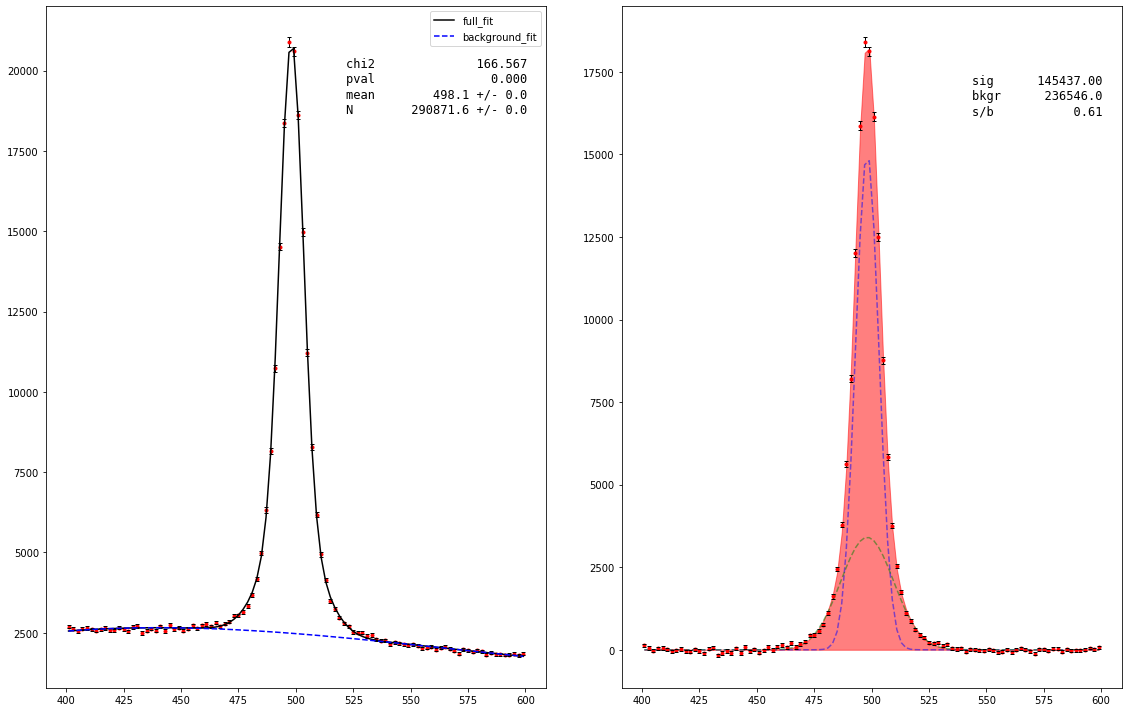

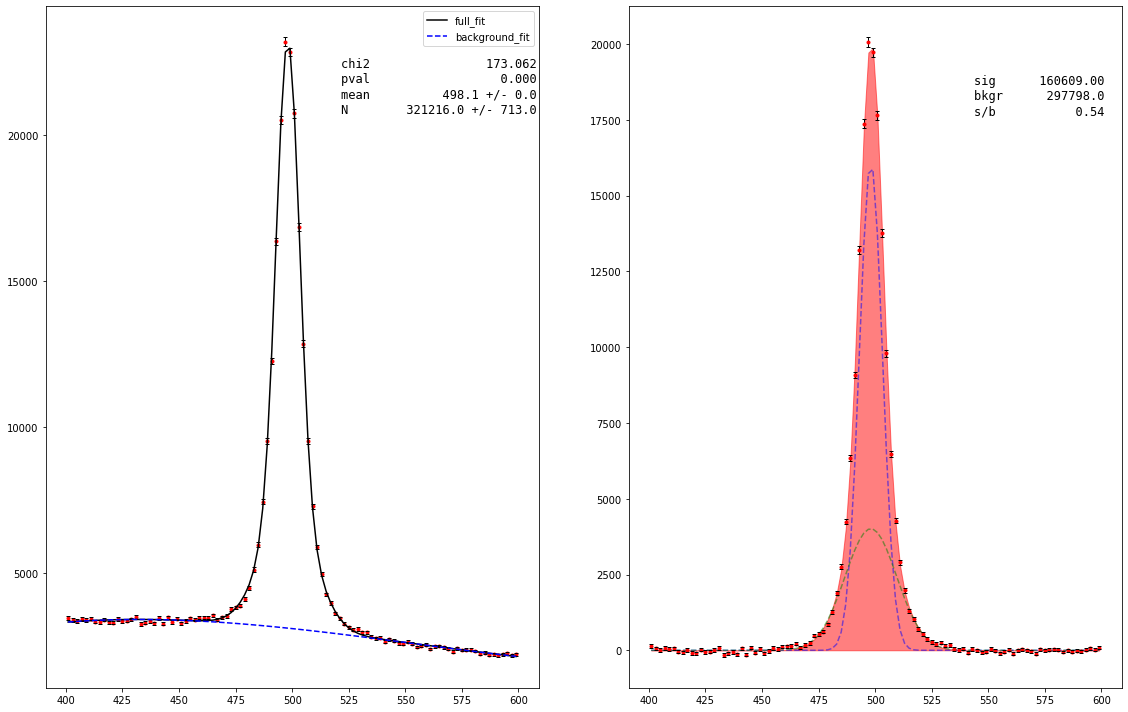

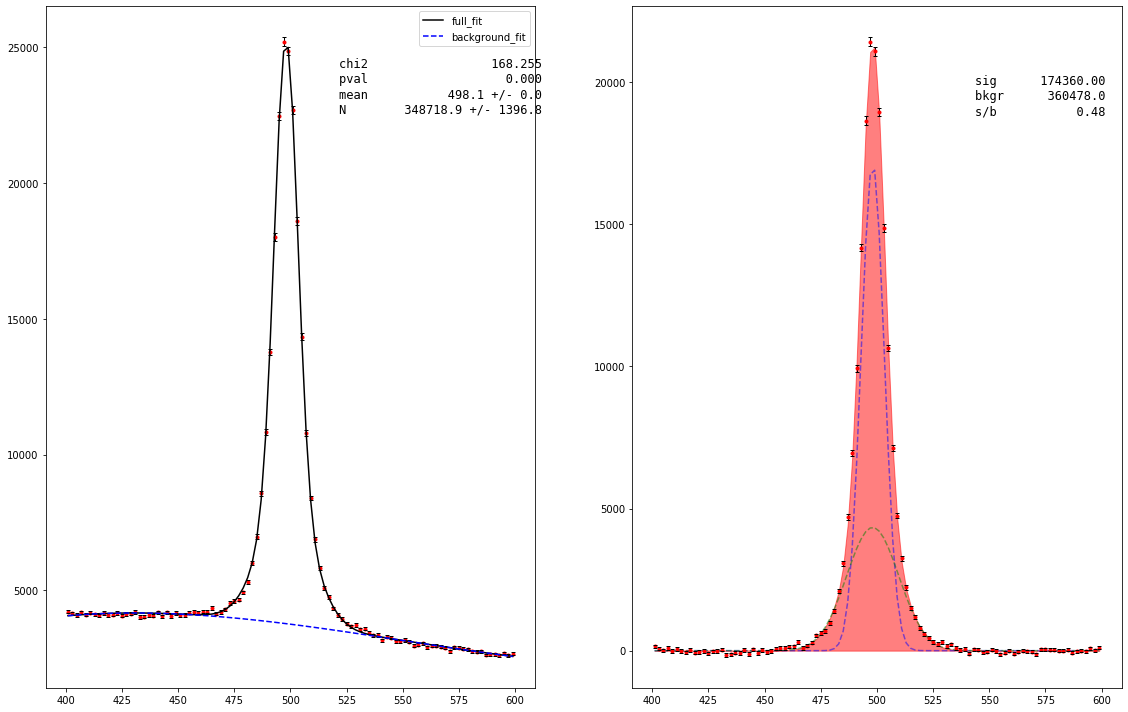

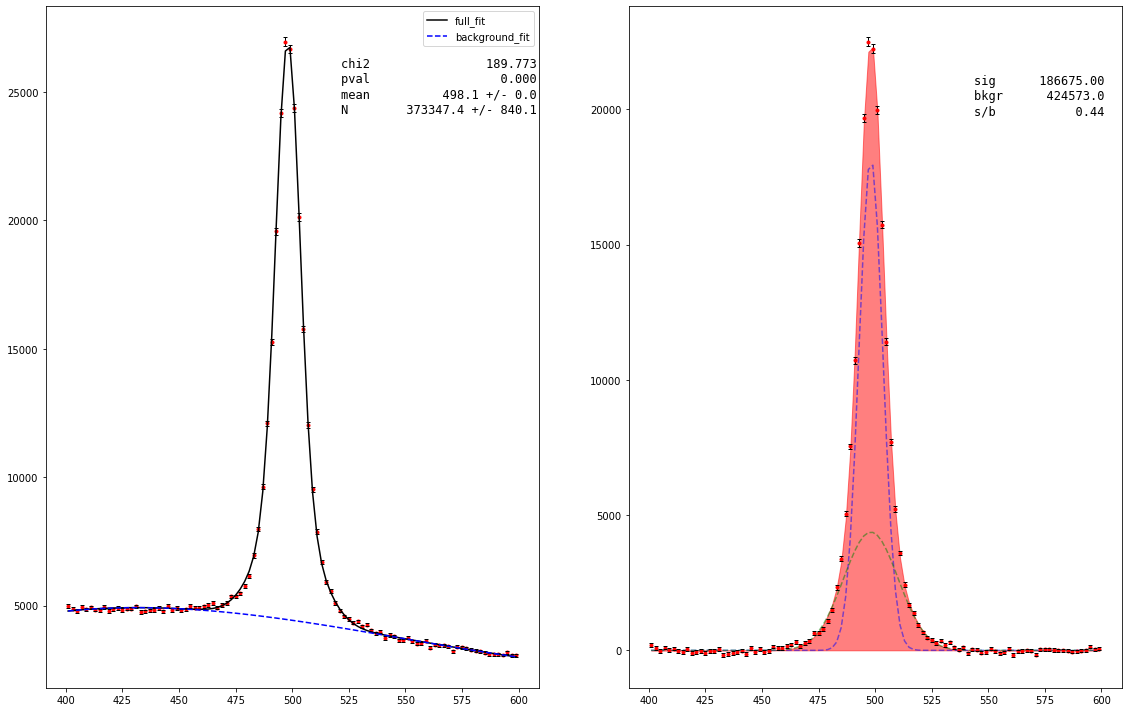

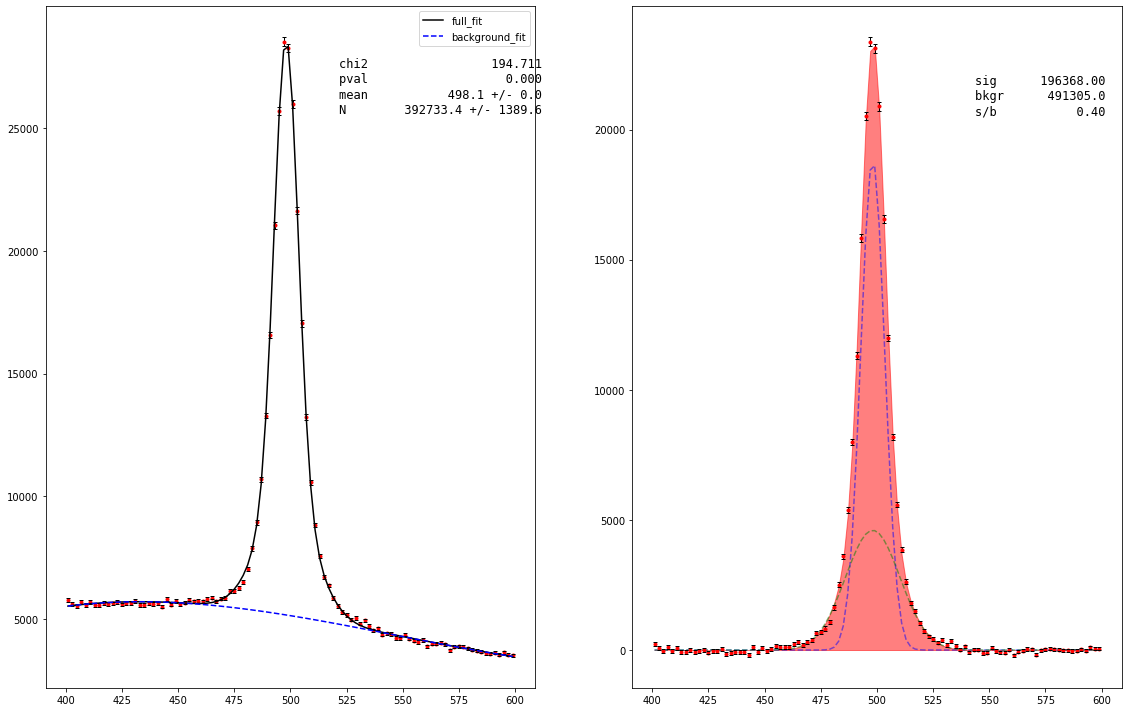

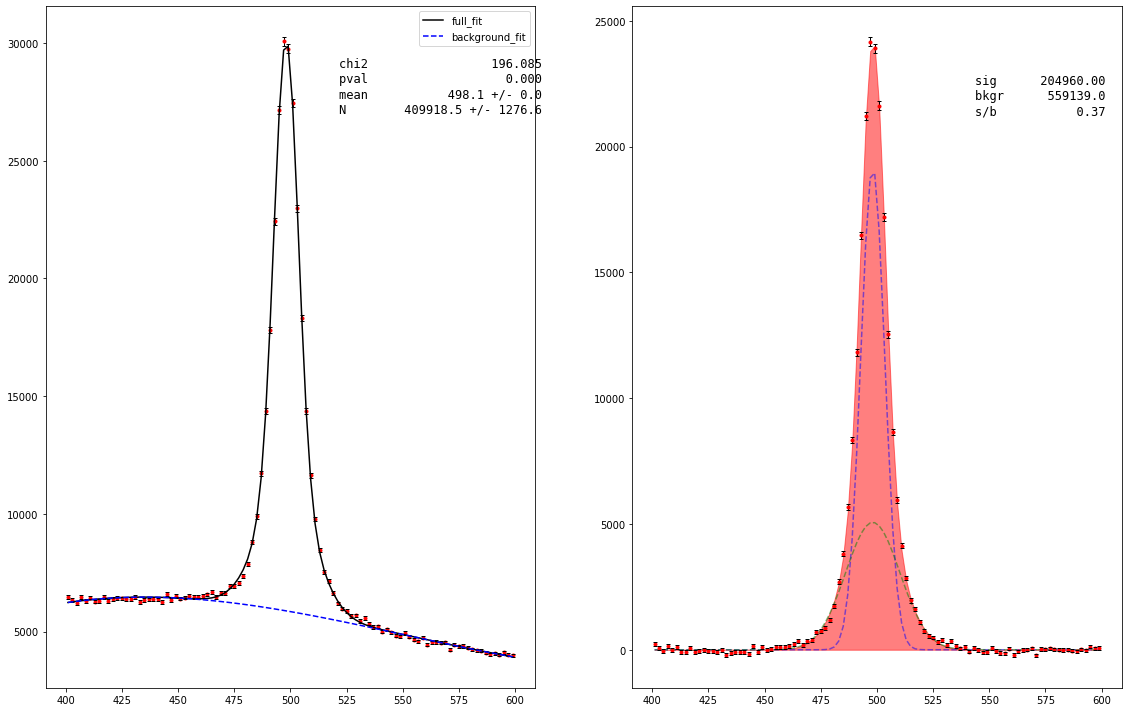

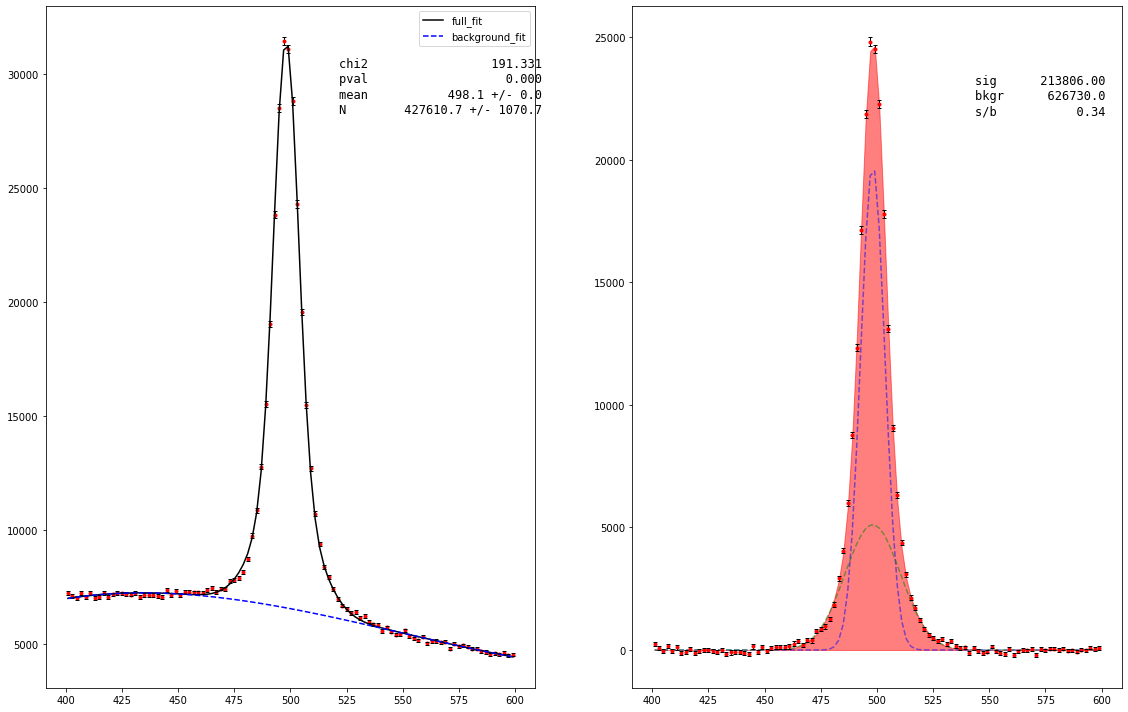

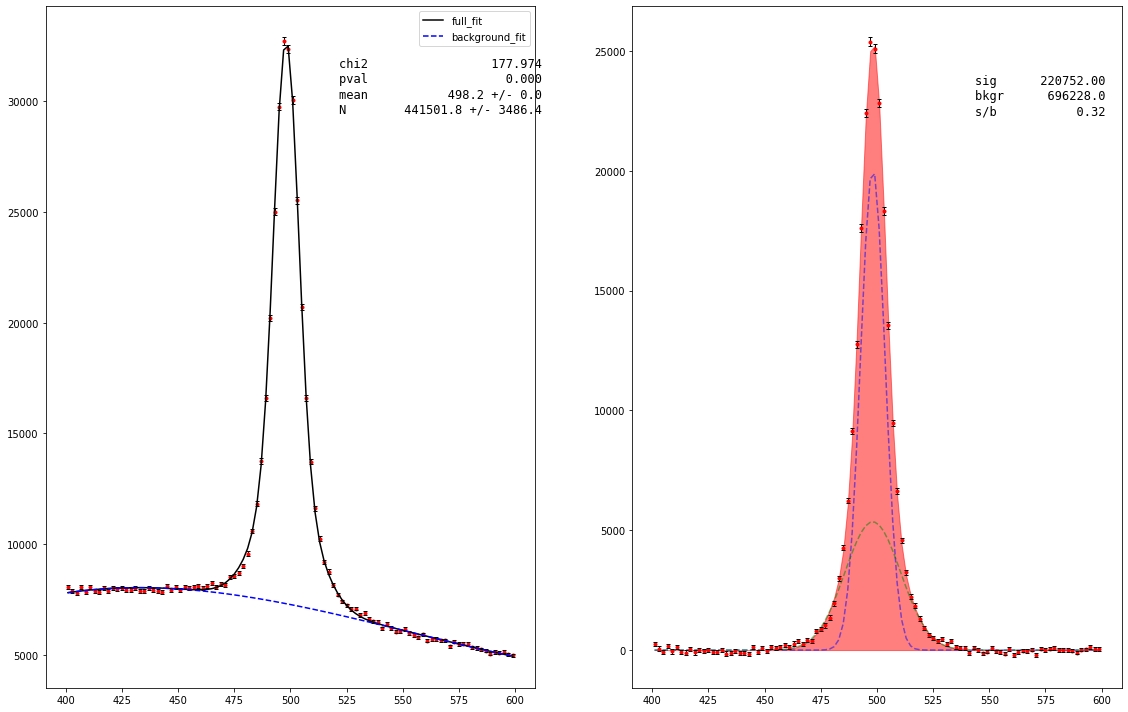

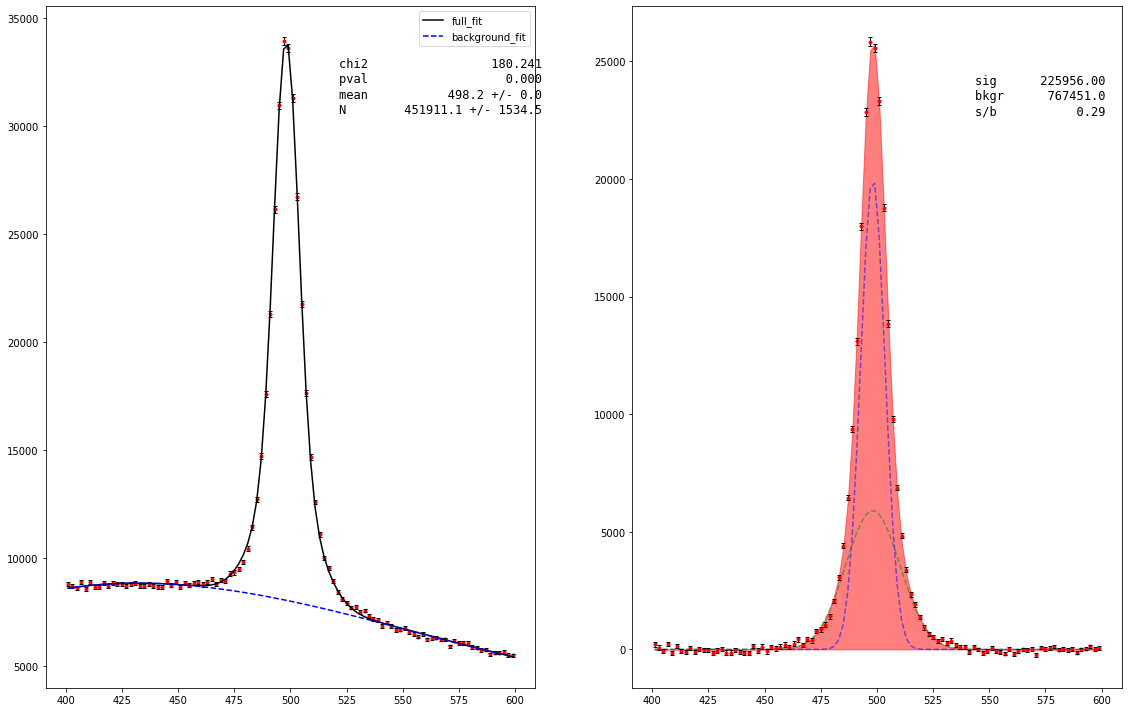

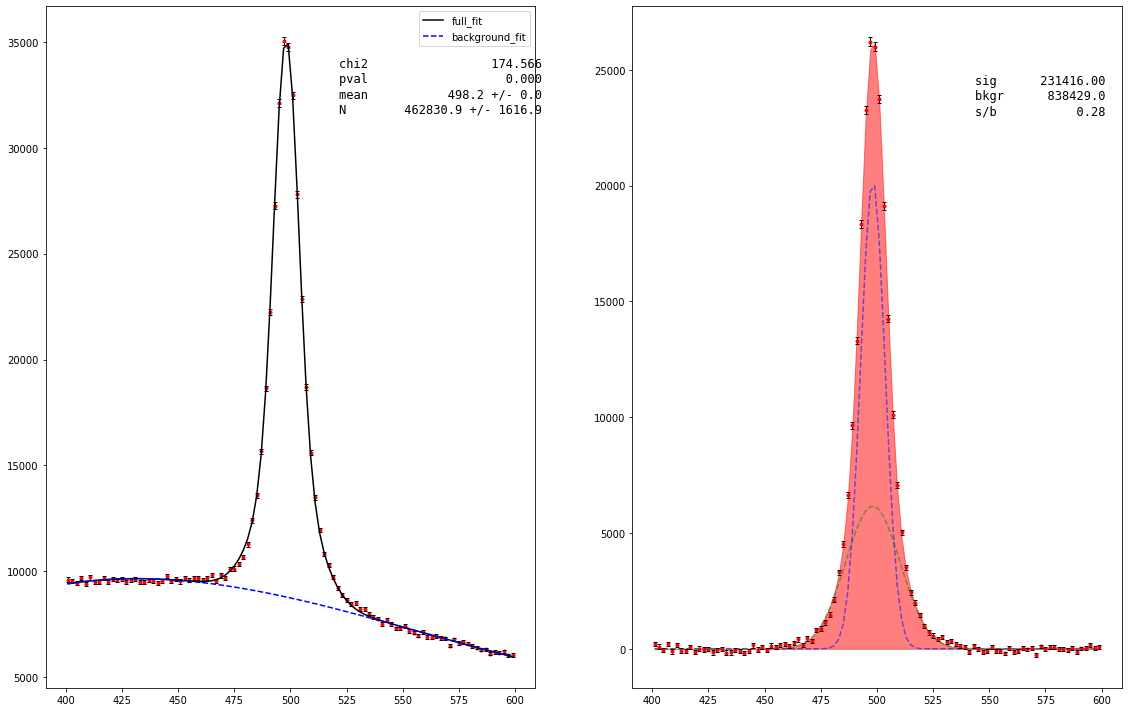

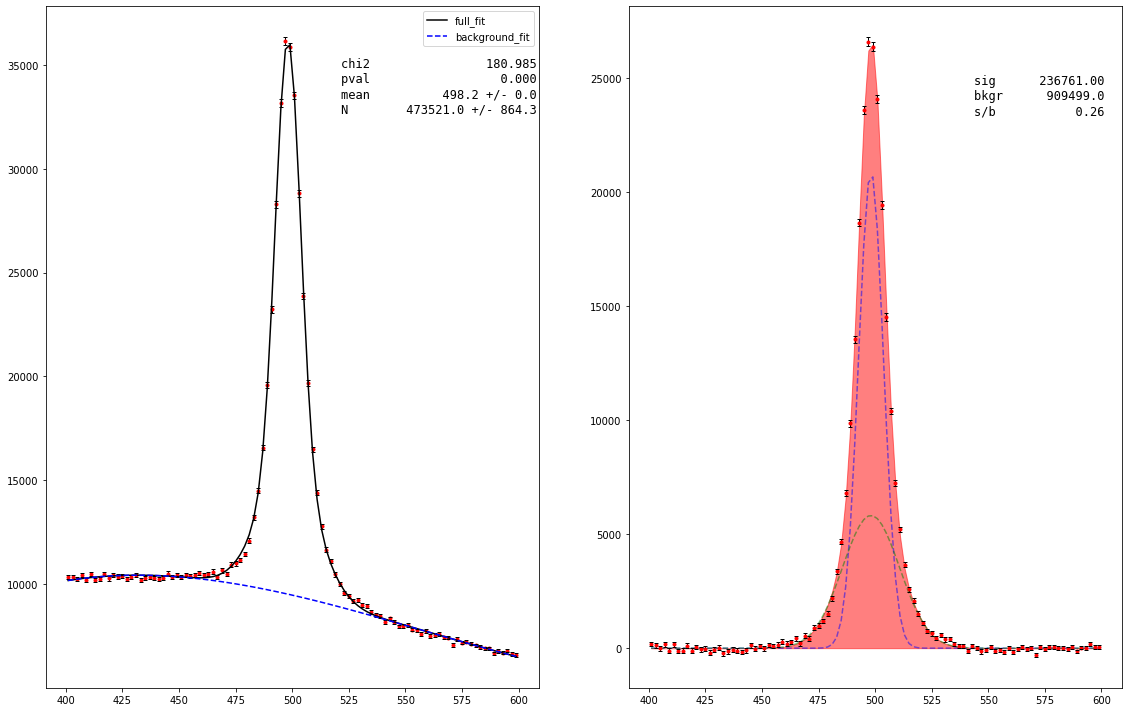

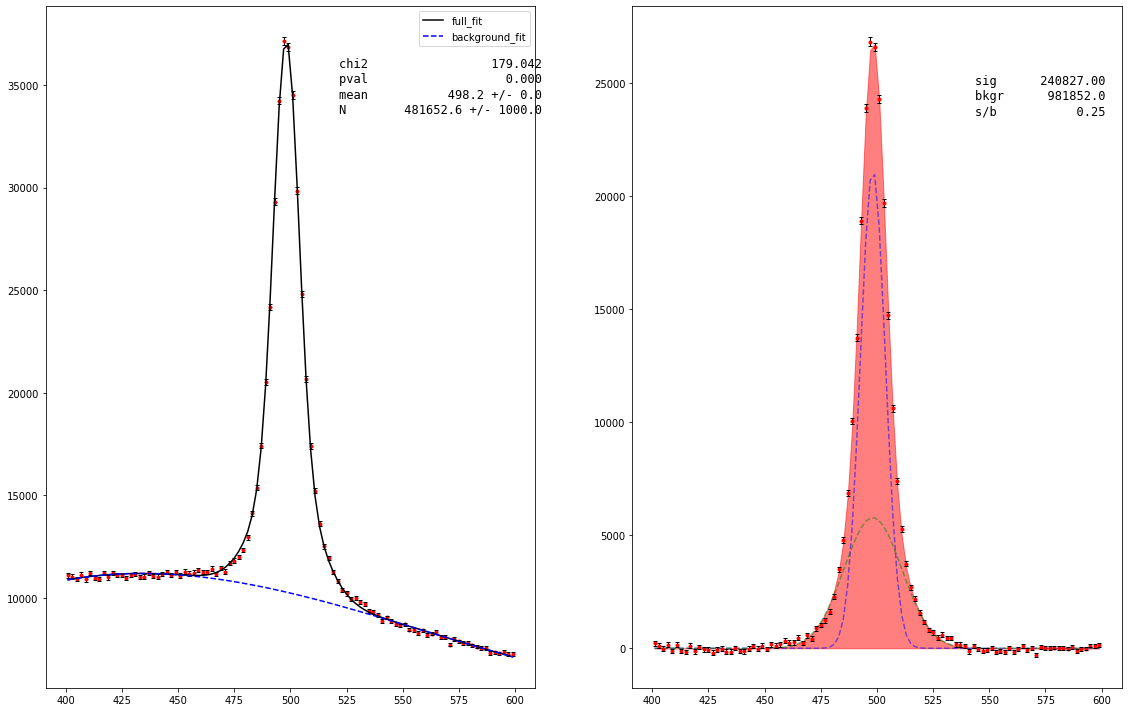

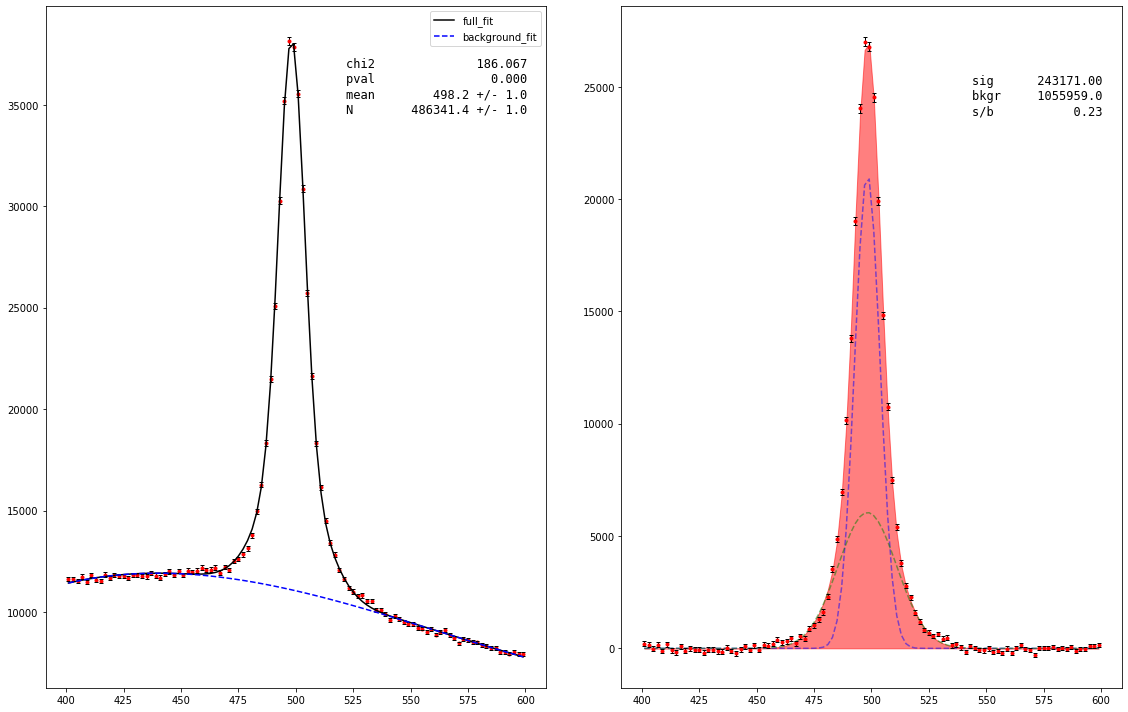

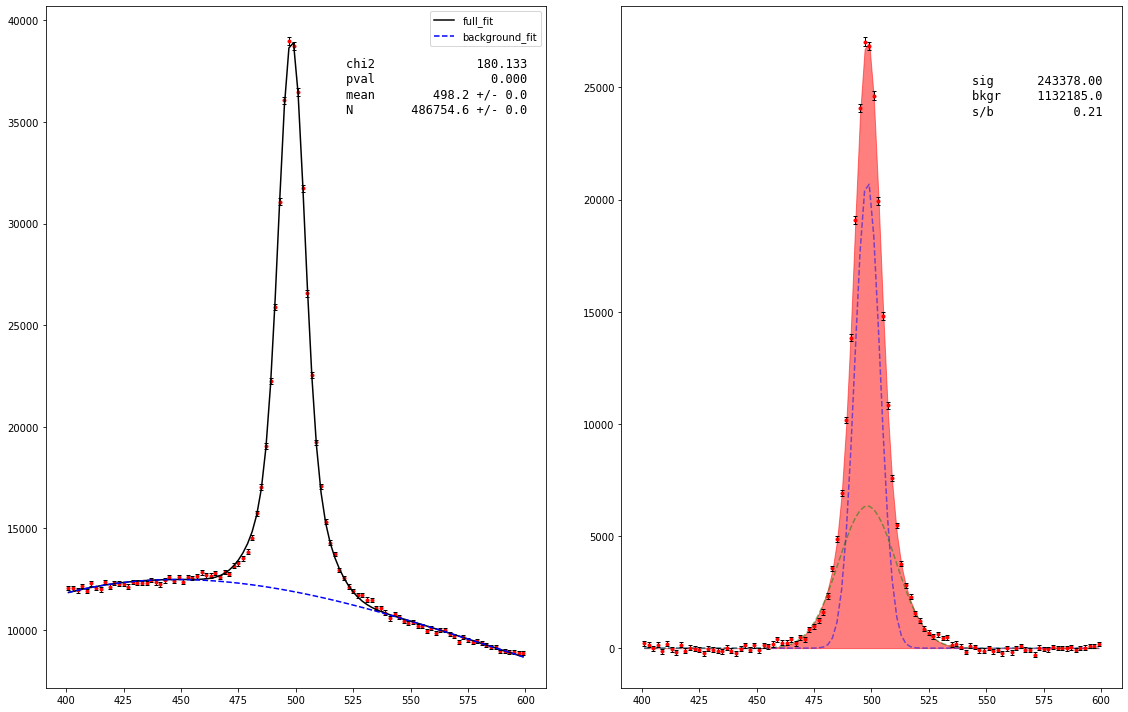

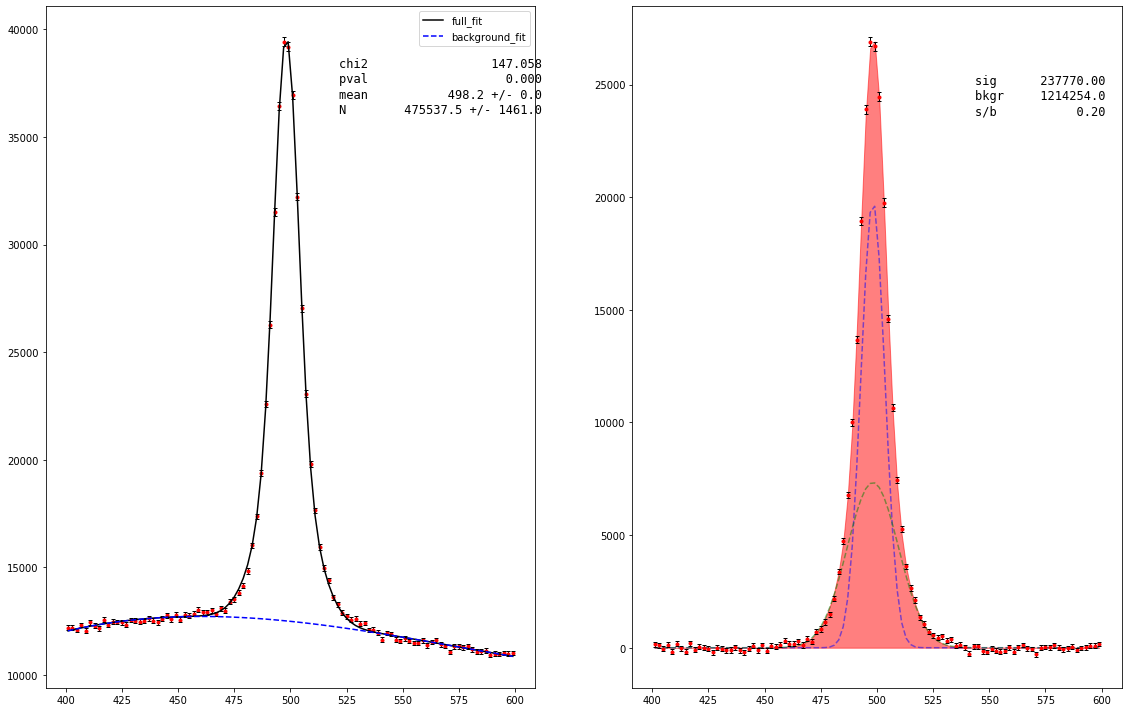

In [134]:
s,b = ROC_data(test_mc.v0_ks_mass,p)

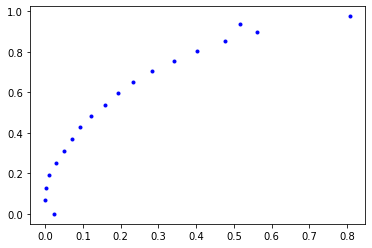

In [135]:
fig, ax = plt.subplots()
ax.plot(1 - np.asarray(s)/max(s), 1 - np.asarray(b)/max(b),'b.')

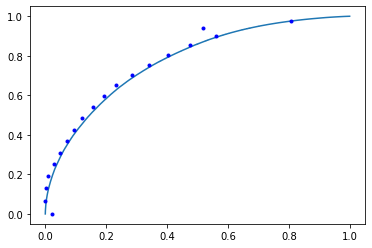

In [136]:
from sklearn.metrics import roc_curve, roc_auc_score
a = roc_curve(test_mc.trueKs,p)

fig, ax = plt.subplots()
ax.plot(a[1],a[0])
ax.plot(1 - np.asarray(s)/max(s), 1 - np.asarray(b)/max(b),'b.')